In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))

# Conf Learn, FKDN different corruptions
- Low recall in Confident Learning is due to its noise model assumptions

In [12]:
from constants.teacher_models import TEACHER_MODELS
from util.create_artificial_dataset import corrupt_sln, corrupt_ccn, corrupt_iln
import pandas as pd
from util.get_out_of_sample_predicted_probabilities_from_teacher_model import get_out_of_sample_predicted_probabilities_from_teacher_model
from util.detectors.conf_learn_detector import Conf_Learn_Detector
from util.detectors.fkdn_detector import FKDN_Detector
import numpy as np
from util.evaluation_metrics import get_evaluation_metrics
import matplotlib.pyplot as plt
from constants.visualization_defaults import FIG_SIZE, FONT_SIZE_PARAMS

plt.rcParams.update({
    'font.size': 18,
    'axes.titlesize': 20,   
    'axes.labelsize': 18,   
    'xtick.labelsize': 16,  
    'ytick.labelsize': 16,  
    'legend.fontsize': 18   
}) 


In [13]:
figsize = FIG_SIZE

In [14]:
teacher_name, teacher_model = TEACHER_MODELS[0]
dataset = 'music_most_values'

general_dataset = dataset.replace("_most_values", '') if 'most_values' in dataset else dataset
data = pd.read_csv(f"../../datasets/{general_dataset}/preprocessed_{dataset}.csv")

iln_corrupted = corrupt_iln(data, teacher_model=teacher_model, dataset=dataset)
sln_corrupted = corrupt_sln(data, 0.02)
ccn_corrupted = corrupt_ccn(data, 0.017, 0.1)

In [15]:
print(f'SLN =  {((len(sln_corrupted[sln_corrupted["label"] != sln_corrupted["noisy_label"]]) / len(sln_corrupted)) * 100):.3f} %')
print(f'CCN =  {((len(ccn_corrupted[ccn_corrupted["label"] != ccn_corrupted["noisy_label"]]) / len(ccn_corrupted)) * 100):.3f} %')
print(f'ILN =  {((len(iln_corrupted[iln_corrupted["label"] != iln_corrupted["noisy_label"]]) / len(iln_corrupted)) * 100):.3f} %')

SLN =  1.995 %
CCN =  2.064 %
ILN =  2.024 %


In [16]:
datasets = [
    ('RLN', iln_corrupted),
    ('SLN', sln_corrupted),
    ('CCN', ccn_corrupted)
]


detectors = [
    ('Confident Learning', Conf_Learn_Detector),
    ('FKDN', FKDN_Detector)
]

constant_fn_result = []

for (dataset_name, dataset) in datasets:
    for (detector_name, detector) in detectors: 
        corrupted_data = dataset
        corrupted_feature_data = corrupted_data.drop(["label", "noisy_label"], axis=1)

        detector_instance = detector()
        issue_indices = detector_instance.detect(corrupted_feature_data, corrupted_data["noisy_label"].to_numpy())

        y_pred = [1 if i in issue_indices else 0 for i in np.arange(0, len(corrupted_data), 1)]
        y_true = corrupted_data.apply(lambda row: 0 if row["label"] == row["noisy_label"] else 1, axis=1).to_numpy()

        noise_rate = len(corrupted_data[corrupted_data["label"] != corrupted_data["noisy_label"]]) / len(corrupted_data)

        acc, precision, recall, f1, f05, cm, precision_over_noise = get_evaluation_metrics(y_true, y_pred, noise_rate)

        constant_fn_result.append({
            'noise_rate': noise_rate,
            'recall': recall,
            'detector': detector_name,
            'dataset': dataset_name
        })

        print(noise_rate, recall)


0.020241698900974204 0.24962901896125309
0.020241698900974204 0.8333058532563892
0.019948002362922147 0.9742345658357036
0.019948002362922147 0.9912999832691985
0.020635519258816737 0.9689471130519165
0.020635519258816737 0.9692705806242924


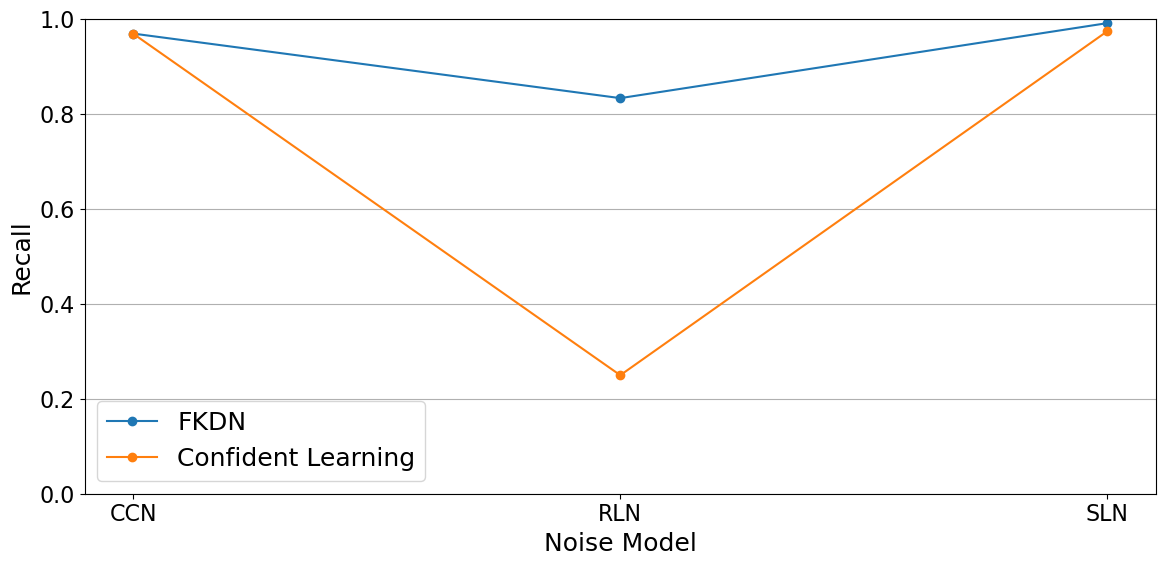

In [17]:
data = constant_fn_result

detectors = set(d['detector'] for d in data)
datasets = sorted(set(d['dataset'] for d in data))

plt.figure(figsize=(12, 6))

for detector in detectors:
    detector_data = sorted([d for d in data if d['detector'] == detector], key=lambda x: x['dataset'])
    recalls = [d['recall'] for d in detector_data]
    plt.plot(datasets, recalls, label=detector, marker='o')

plt.xlabel('Noise Model')
plt.ylabel('Recall')
plt.ylim(0,1)
plt.grid(axis='y')
plt.legend()
plt.tight_layout()
plt.show()

# Precision over noise 

In [8]:
import sys
import os
sys.path.append(os.path.abspath(".."))

import matplotlib.pyplot as plt
import pandas as pd
from util.flatten_evaluation_items import flatten_evaluation_items
import json
import numpy as np

from constants.visualization_defaults import FIG_SIZE, FONT_SIZE_PARAMS

plt.rcParams.update(FONT_SIZE_PARAMS) 

In [9]:
def get_full_evaluation_data(dataset):
    conf_learn_fkdn_results_path = f'../../results/evaluation_{dataset}/conf_learn_fkdn_evaluation.json'
    cvcf_results_path = f'../../results/evaluation_{dataset}/cvcf.json'
    harf_results_path = f'../../results/evaluation_{dataset}/harf.json'

    with open(conf_learn_fkdn_results_path, "r") as f:
        conf_learn_fkdn_data = json.load(f)

    with open(cvcf_results_path, "r") as f:
        cvcf_data = json.load(f)

    with open(harf_results_path, "r") as f:
        harf_data = json.load(f)

    full_data = conf_learn_fkdn_data + cvcf_data + harf_data
    full_data = [flatten_evaluation_items(data) for data in full_data]

    df = pd.DataFrame(full_data)
    
    lookup = {
        'conf_learn': 'Confident Learning',
        'fkdn': 'FKDN',
        'cvcf': 'CVCF',
        'harf': 'HARF',
        'arguable_conf_learn': 'Binary Confident Learning Adjustment',
    }

    df['detector'] = df['detector'].replace(lookup)

    custom_order = ['Confident Learning', 'Binary Confident Learning Adjustment', 'FKDN', 'CVCF', 'HARF']
    df['detector'] = pd.Categorical(df['detector'], categories=custom_order, ordered=True)
    df = df.sort_values('detector')

    return df

In [10]:
column_mapping = {
    "cleaning_precision": "Precision",
    "cleaning_recall": "Recall",
    "cleaning_f1": "F1 Score",
    "cleaning_f05": "F0.5 Score",
    "cleaning_pon": "Precision over Noise"
}

figsize = FIG_SIZE

In [11]:
df = get_full_evaluation_data('music')

df = df[df["detector"] != "Binary Confident Learning Adjustment"]

df["dataset_formatted"] = df.apply(lambda row: "RF" if 'rf' in row["dataset"] else "LSVC" if 'svm' in row["dataset"] else "Tree",axis=1)

custom_order = ['Confident Learning', 'Binary Confident Learning Adjustment', 'FKDN', 'CVCF', 'HARF']
df['detector'] = pd.Categorical(df['detector'], categories=custom_order, ordered=True)
df = df.sort_values('detector')

custom_order = ['RF', 'Tree', 'LSVC']
df['dataset_formatted'] = pd.Categorical(df['dataset_formatted'], categories=custom_order, ordered=True)
df = df.sort_values('dataset_formatted')



df = df[["dataset_formatted", "detector", "cleaning_pon"]]

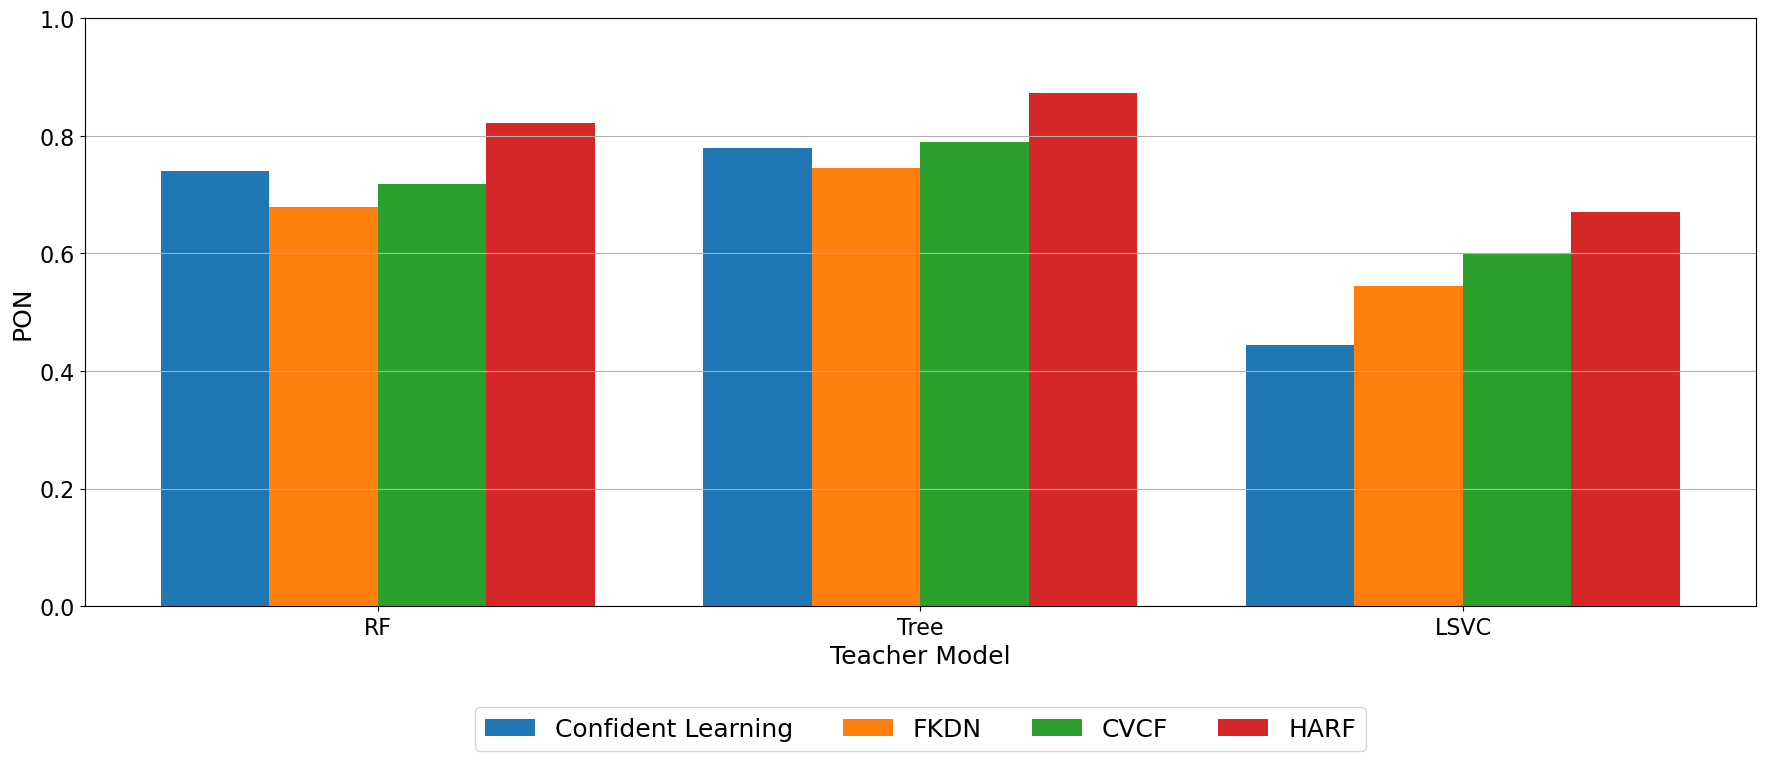

In [13]:
import numpy as np
import matplotlib.pyplot as plt
data = df.to_numpy()
x_labels = ["RF", "Tree", "LSVC"]
methods = ['Confident Learning', 'FKDN', 'CVCF', 'HARF']

x = np.arange(len(x_labels))
width = 0.2

plt.figure(figsize=(18, 8))
for i, method in enumerate(methods):
    values = [float(data[(data[:, 0] == x_label) & (data[:, 1] == method), 2][0]) for x_label in x_labels]
    plt.bar(x + i*width, values, width, label=method)

plt.xticks(x + width*1.5, x_labels)
plt.ylabel('PON')
plt.xlabel("Teacher Model")
plt.ylim(0, 1)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=len(methods))
plt.tight_layout()
plt.grid(axis='y', linestyle='-')
plt.show()


# PCA reduced Music dataset

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


from constants.visualization_defaults import FIG_SIZE, FONT_SIZE_PARAMS

plt.rcParams.update(FONT_SIZE_PARAMS) 

figsize = FIG_SIZE

In [6]:
def get_reduced_data(file):
    data = pd.read_csv(file)

    X = data.drop(["label"], axis=1)
    y = data["label"]

    match_indices = data[data["label"] == 1].index
    non_match_indices = data[data["label"] == 0].index

    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(X)

    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(scaled_data)

    match_pca = X_pca[match_indices]
    non_match_pca = X_pca[non_match_indices]

    return X_pca, y, non_match_pca,  match_pca

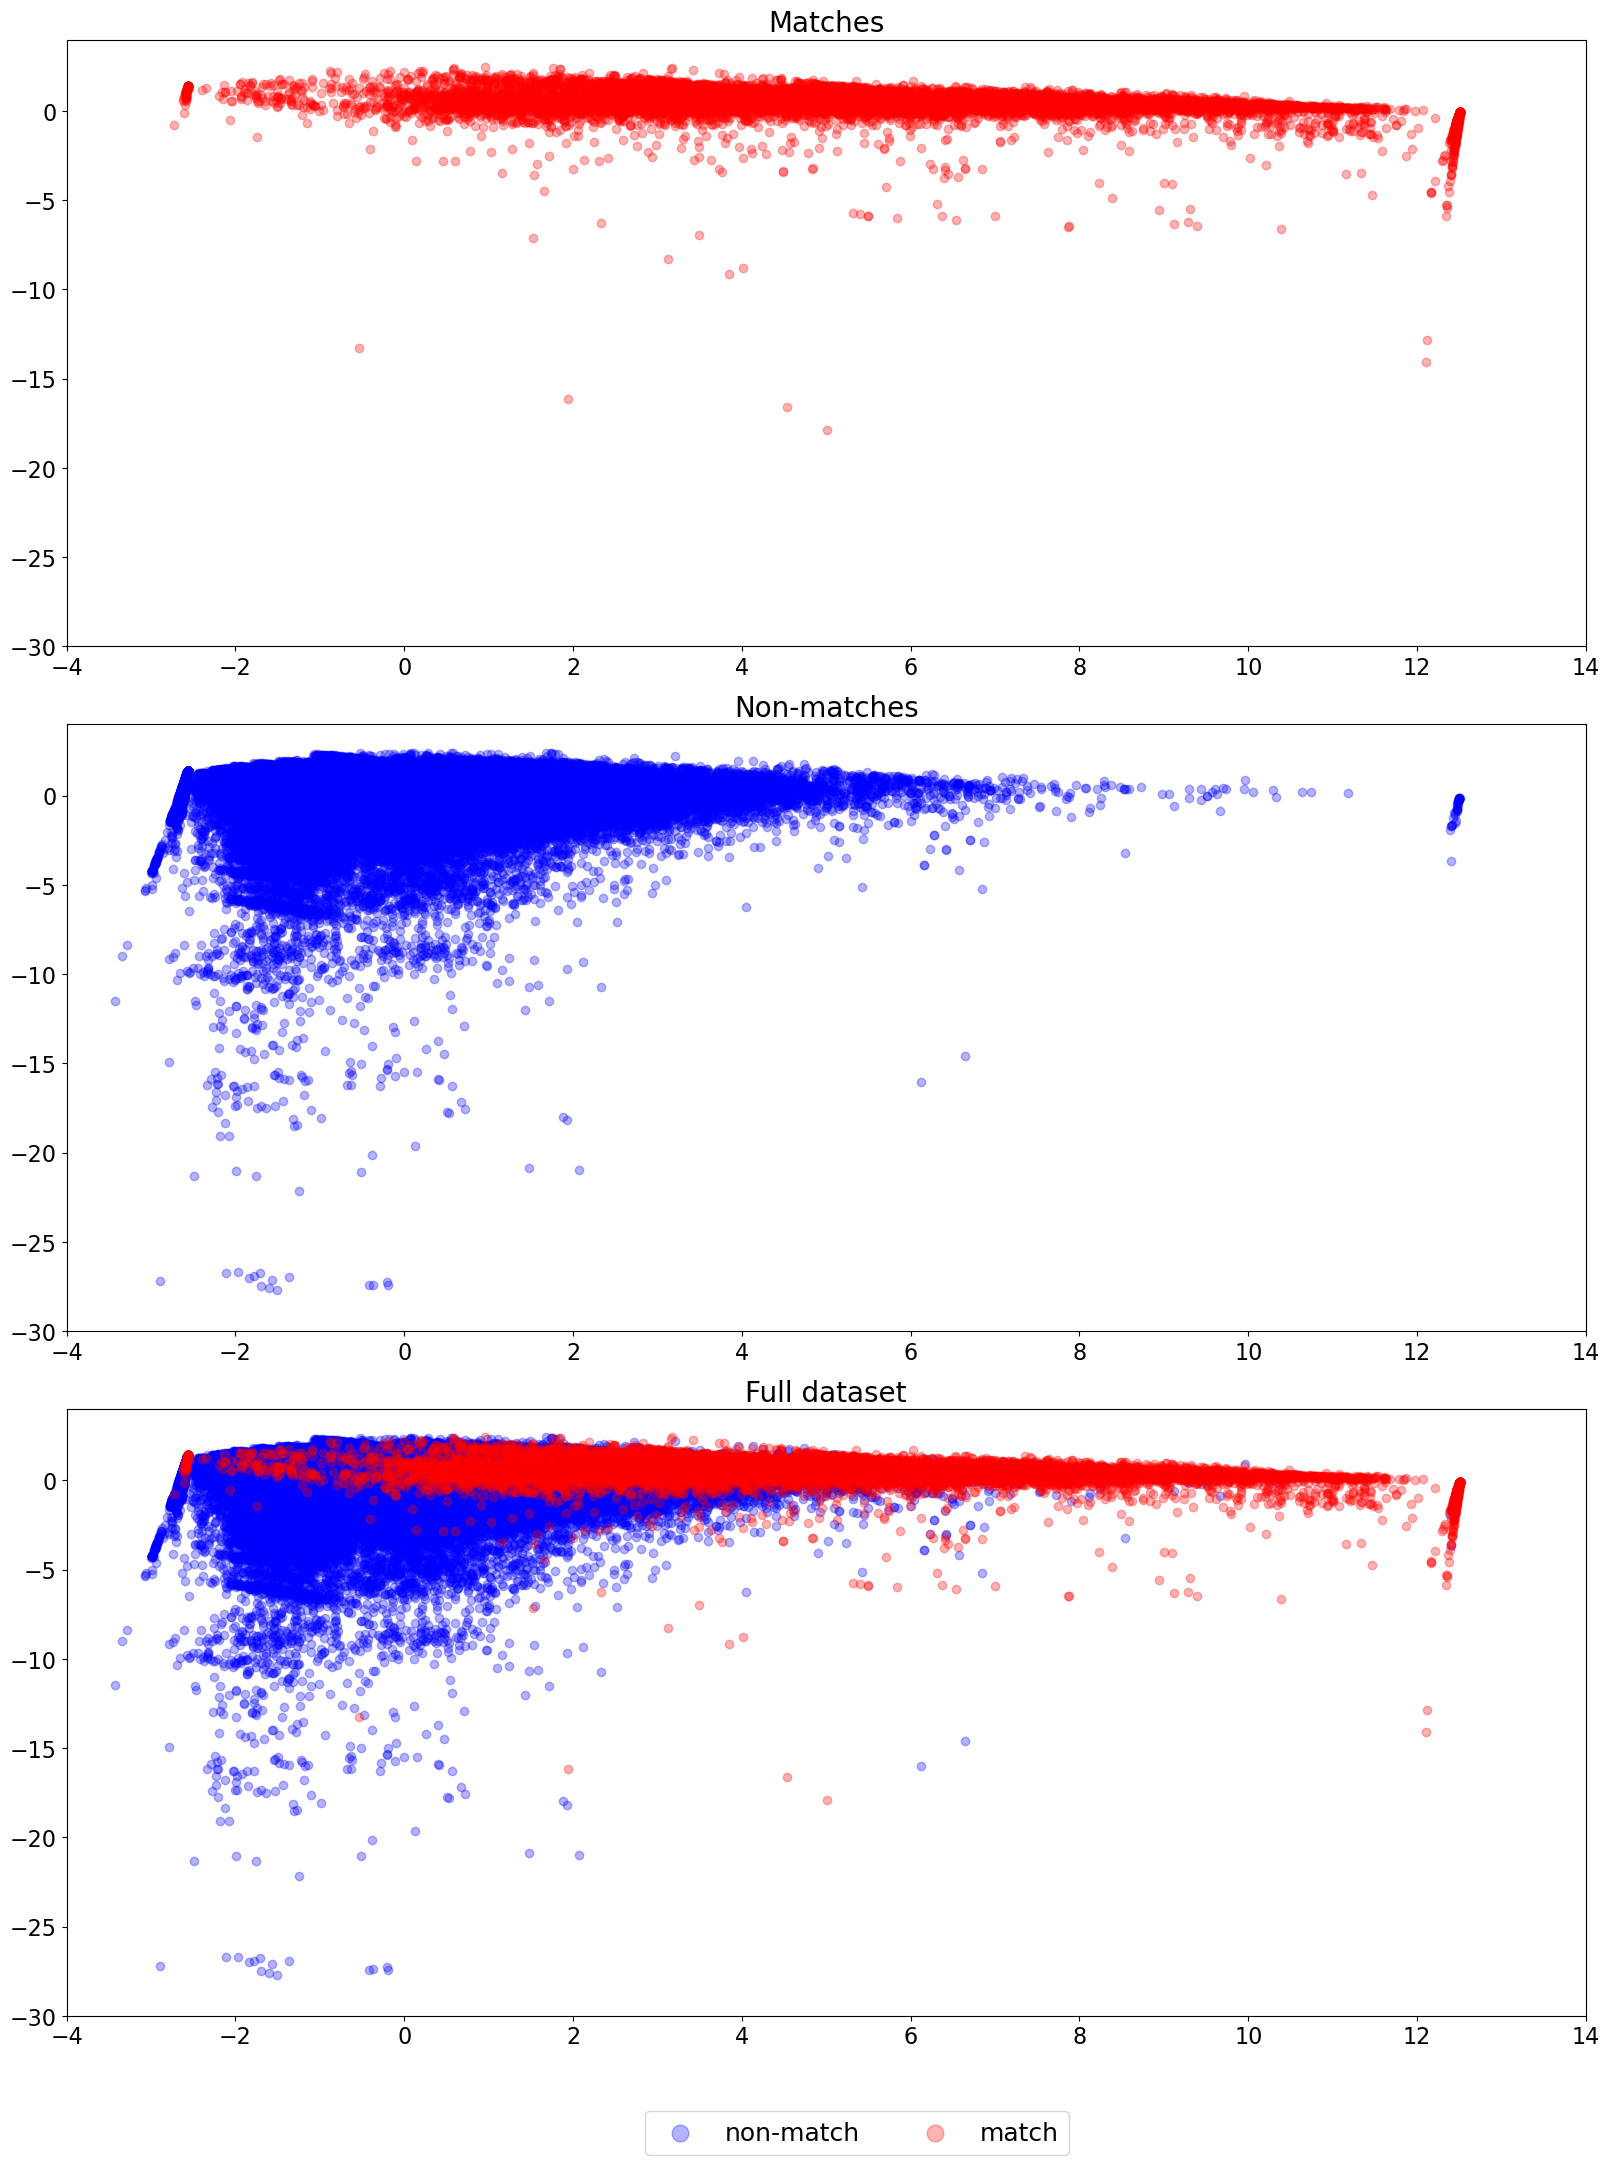

In [14]:
fig, axs = plt.subplots(3, 1, figsize=(18, 24))

file = ("../../datasets/music/preprocessed_music_most_values.csv")

X_pca, y, non_match_pca, match_pca = get_reduced_data(file)



axs[0].scatter(match_pca[:, 0], match_pca[:, 1], color='red', alpha=0.3, label='match')
axs[0].set_xlim(-4, 14)
axs[0].set_ylim(-30, 4)
axs[0].set_xticks([-4, -2, 0, 2, 4, 6, 8, 10, 12, 14])
axs[0].set_yticks([0, -5, -10, -15, -20, -25, -30])
axs[0].set_title("Matches")


axs[1].scatter(non_match_pca[:, 0], non_match_pca[:, 1], color='blue', alpha=0.3, label='non-match')
axs[1].set_xlim(-4, 14)
axs[1].set_ylim(-30, 4)
axs[1].set_xticks([-4, -2, 0, 2, 4, 6, 8, 10, 12, 14])
axs[1].set_yticks([0, -5, -10, -15, -20, -25, -30])
axs[1].set_title("Non-matches")

axs[2].scatter(non_match_pca[:, 0], non_match_pca[:, 1], color='blue', alpha=0.3, label='non-match')
axs[2].scatter(match_pca[:, 0], match_pca[:, 1], color='red', alpha=0.3, label='match')
axs[2].set_xlim(-4, 14)
axs[2].set_ylim(-30, 4)
axs[2].set_xticks([-4, -2, 0, 2, 4, 6, 8, 10, 12, 14])
axs[2].set_yticks([0, -5, -10, -15, -20, -25, -30])
axs[2].set_title("Full dataset")



plt.legend(loc='lower center', bbox_to_anchor=(0.52, -0.25),
           ncol=2, markerscale=2,   )

plt.tight_layout(rect=[0.05, 0.05, 0.95, 0.95]) 
plt.show()


# Mislabeled instances in Music dataset

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA



In [15]:
figsize = (24, 16) 
plt.rcParams.update(
 {
    'axes.titlesize': 24,   
    'axes.labelsize': 22,   
    'xtick.labelsize': 16,  
    'ytick.labelsize': 16,  
    'legend.fontsize': 22   
}) 

In [16]:
def get_reduced_data(file):
    data = pd.read_csv(file)

    X = data.drop(["label", "noisy_label"], axis=1)
    y = data["label"]

    match_indices = data[data["label"] == 1].index
    non_match_indices = data[data["label"] == 0].index

    mislabeled_indices = data[data["label"] != data["noisy_label"]].index
    mislabeled_match_indices = data[(data["label"] == 1) & (data["noisy_label"] == 0)].index
    mislabeled_non_match_indices = data[(data["label"] == 0) & (data["noisy_label"] == 1)].index

    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(X)

    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(scaled_data)

    mislabeled_pca = X_pca[mislabeled_indices]
    match_pca = X_pca[match_indices]
    non_match_pca = X_pca[non_match_indices]
    mislabeled_match_pca = X_pca[mislabeled_match_indices]
    mislabeled_non_match_pca = X_pca[mislabeled_non_match_indices]

    colors = data.iloc[mislabeled_indices].apply(lambda row: 'blue' if row["noisy_label"] == 0 else 'red', axis=1)

    return X_pca, y, non_match_pca, mislabeled_non_match_pca, match_pca, mislabeled_match_pca, mislabeled_pca, colors

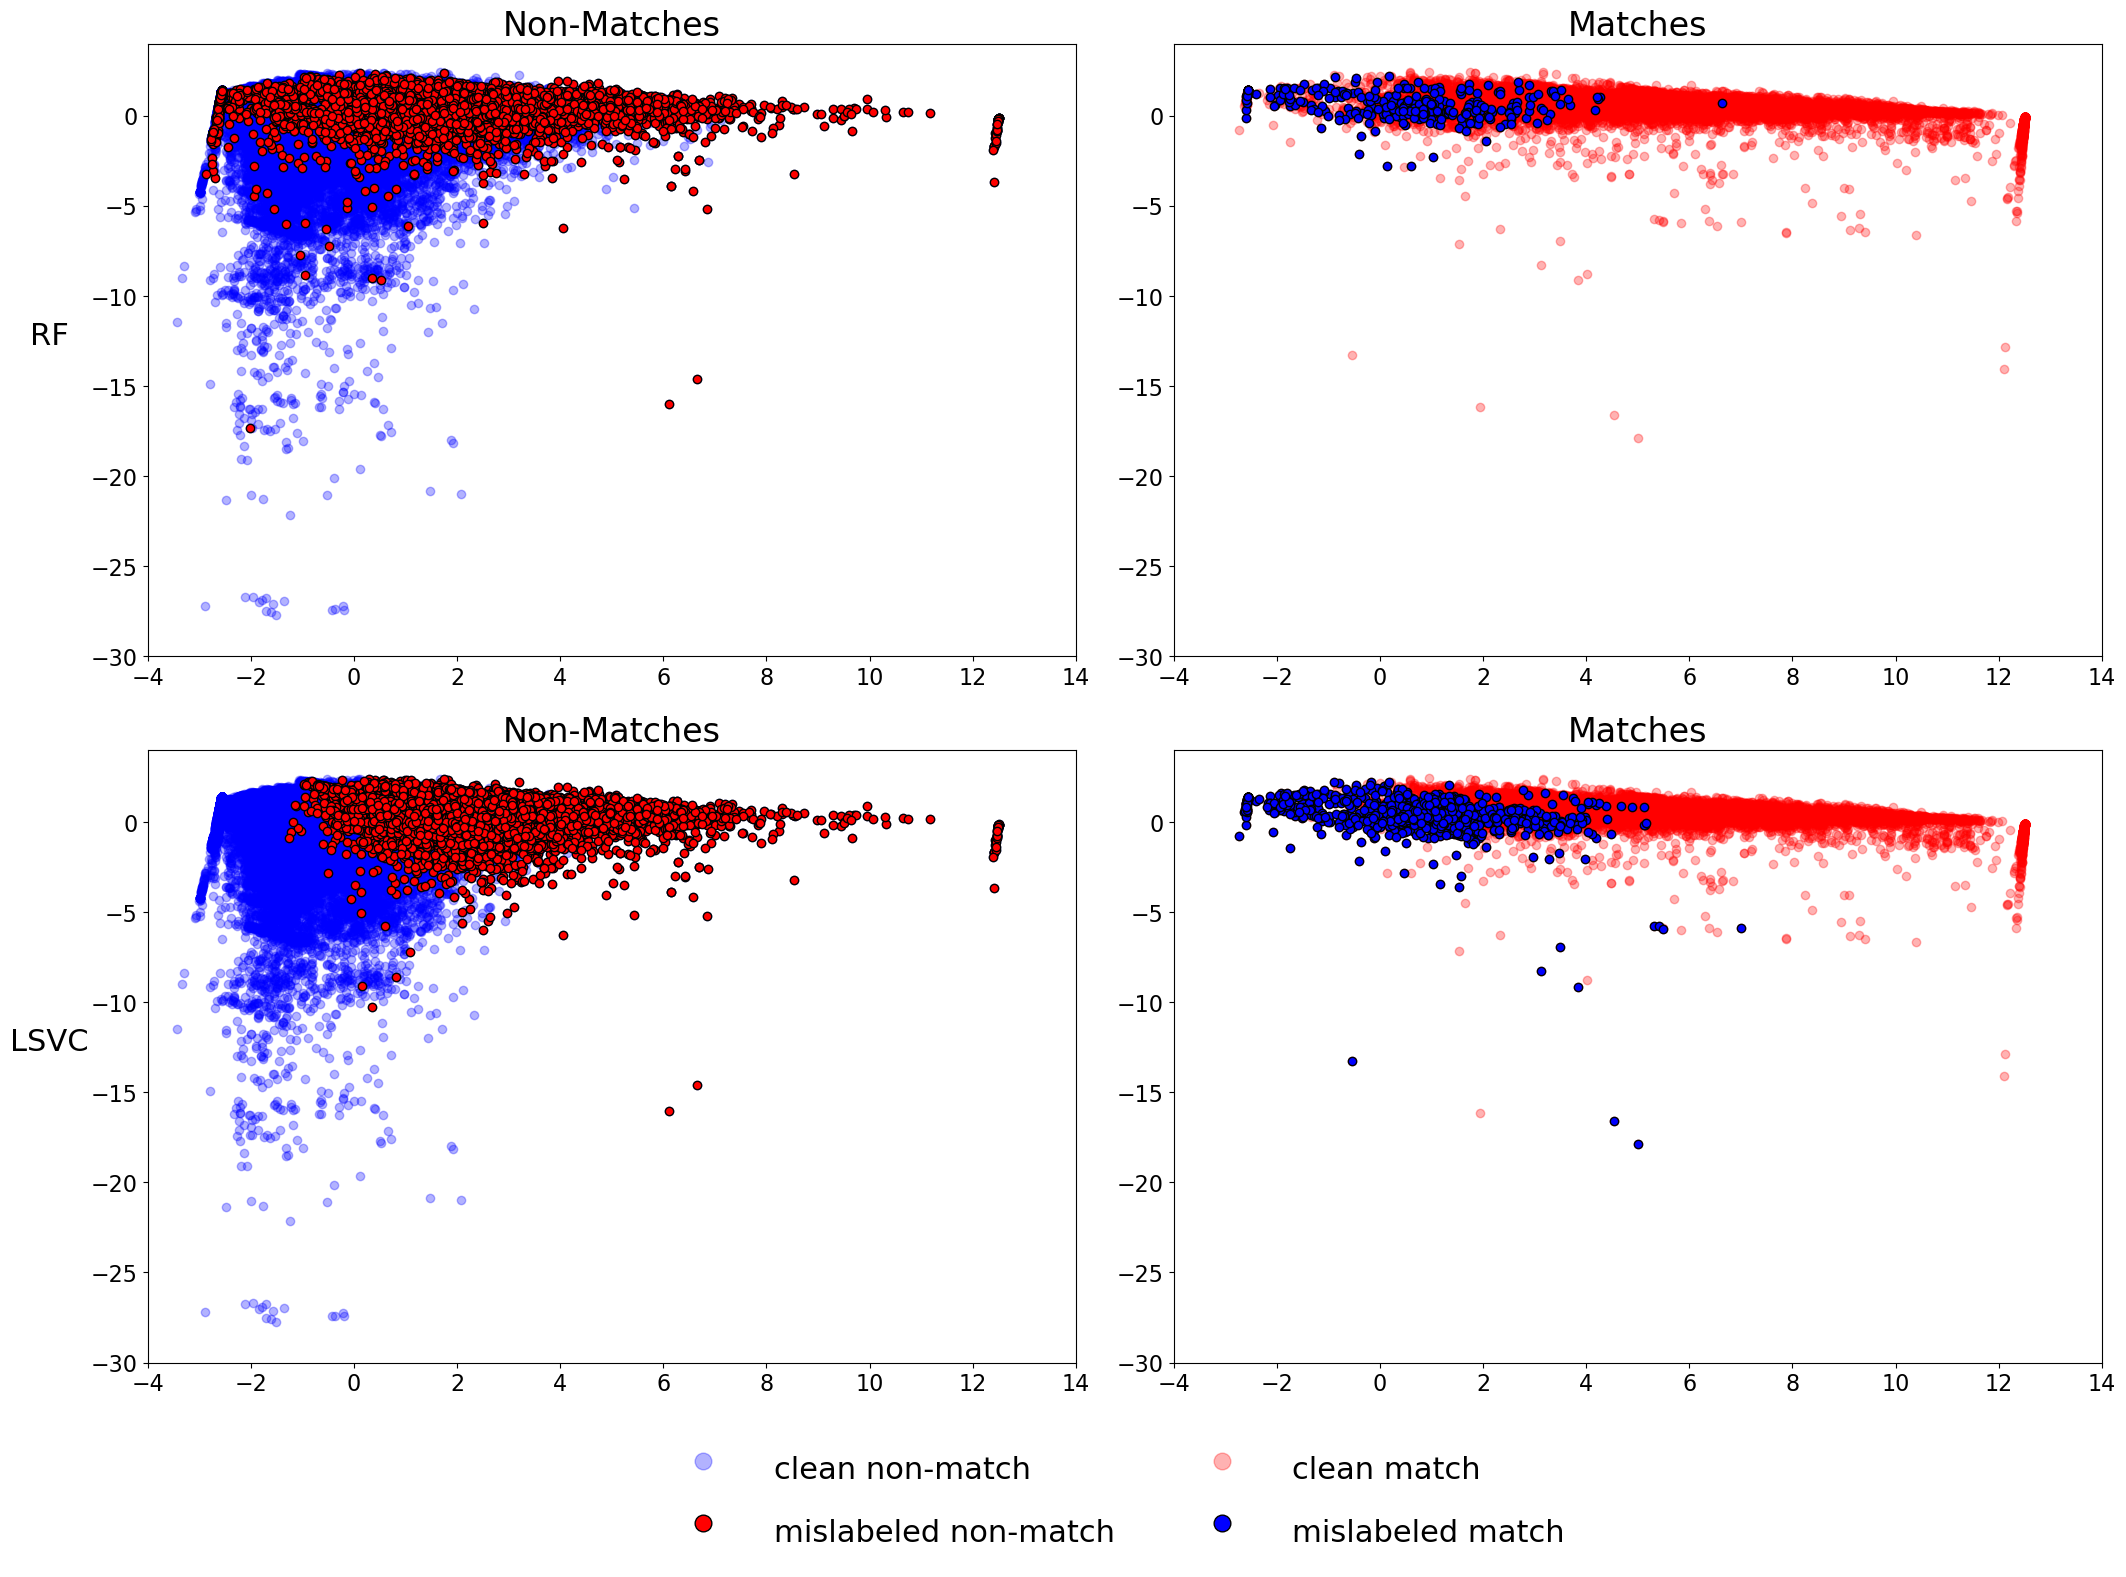

In [17]:
fig, axs = plt.subplots(2, 2, figsize=figsize)

files = [
 ("../../datasets/music/music_most_values_rf_corrupted.csv"),
 ("../../datasets/music/music_most_values_svm_corrupted.csv")
]

for row_index, file in enumerate(files):

    X_pca, y, non_match_pca, mislabeled_non_match_pca, match_pca, mislabeled_match_pca, mislabeled_pca, colors = get_reduced_data(file)

    axs[row_index][0].set_title('Non-Matches')
    axs[row_index][0].scatter(non_match_pca[:, 0], non_match_pca[:, 1],  color='blue', alpha=0.3, label='clean non-match')
    axs[row_index][0].scatter(mislabeled_non_match_pca[:, 0], mislabeled_non_match_pca[:, 1], color='red', edgecolors='black', alpha=1, label='mislabeled non-match')
    axs[row_index][0].set_xlim(-4, 14)
    axs[row_index][0].set_ylim(-30, 4)
    axs[row_index][0].set_xticks([-4, -2, 0, 2, 4, 6, 8, 10, 12, 14])
    axs[row_index][0].set_yticks([0, -5, -10, -15, -20, -25, -30])


    axs[row_index][1].set_title('Matches')
    axs[row_index][1].scatter(match_pca[:, 0], match_pca[:, 1],  color='red', alpha=0.3, label='clean match')
    axs[row_index][1].scatter(mislabeled_match_pca[:, 0], mislabeled_match_pca[:, 1], color='blue', edgecolors='black', alpha=1, label='mislabeled match')
    axs[row_index][1].set_xlim(-4, 14)
    axs[row_index][1].set_ylim(-30, 4)
    axs[row_index][1].set_xticks([-4, -2, 0, 2, 4, 6, 8, 10, 12, 14])
    axs[row_index][1].set_yticks([0, -5, -10, -15, -20, -25, -30])


row_titles = ['RF', 'LSVC']
for i, title in enumerate(row_titles):
    axs[i, 0].set_ylabel(title, labelpad=30, rotation=0, loc='center')

handles = []
all_labels = []

axs = axs.flatten()

for i, ax in enumerate(axs):

    h, l = ax.get_legend_handles_labels()
    handles.extend(h)
    all_labels.extend(l)
    if i == 1:
        break

fig.legend(handles, all_labels, loc='lower center',
           bbox_to_anchor=(0.52, -0.05),
           ncol=2, frameon=False, markerscale=2,   
           handlelength=3, 
           handleheight=2)

plt.tight_layout(rect=[0.05, 0.05, 0.95, 0.95]) 
plt.show()


# FKDN detected mislabeled instances

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from util.detectors.fkdn_detector import FKDN_Detector

In [19]:
figsize = (24, 16) 
plt.rcParams.update(
 {
    'axes.titlesize': 24,   
    'axes.labelsize': 22,   
    'xtick.labelsize': 16,  
    'ytick.labelsize': 16,  
    'legend.fontsize': 22   
}) 

../../datasets/music/music_most_values_rf_corrupted.csv
number matches in fn = 162 | number non-matches in fn = 1007
../../datasets/music/music_most_values_svm_corrupted.csv
number matches in fn = 908 | number non-matches in fn = 9651


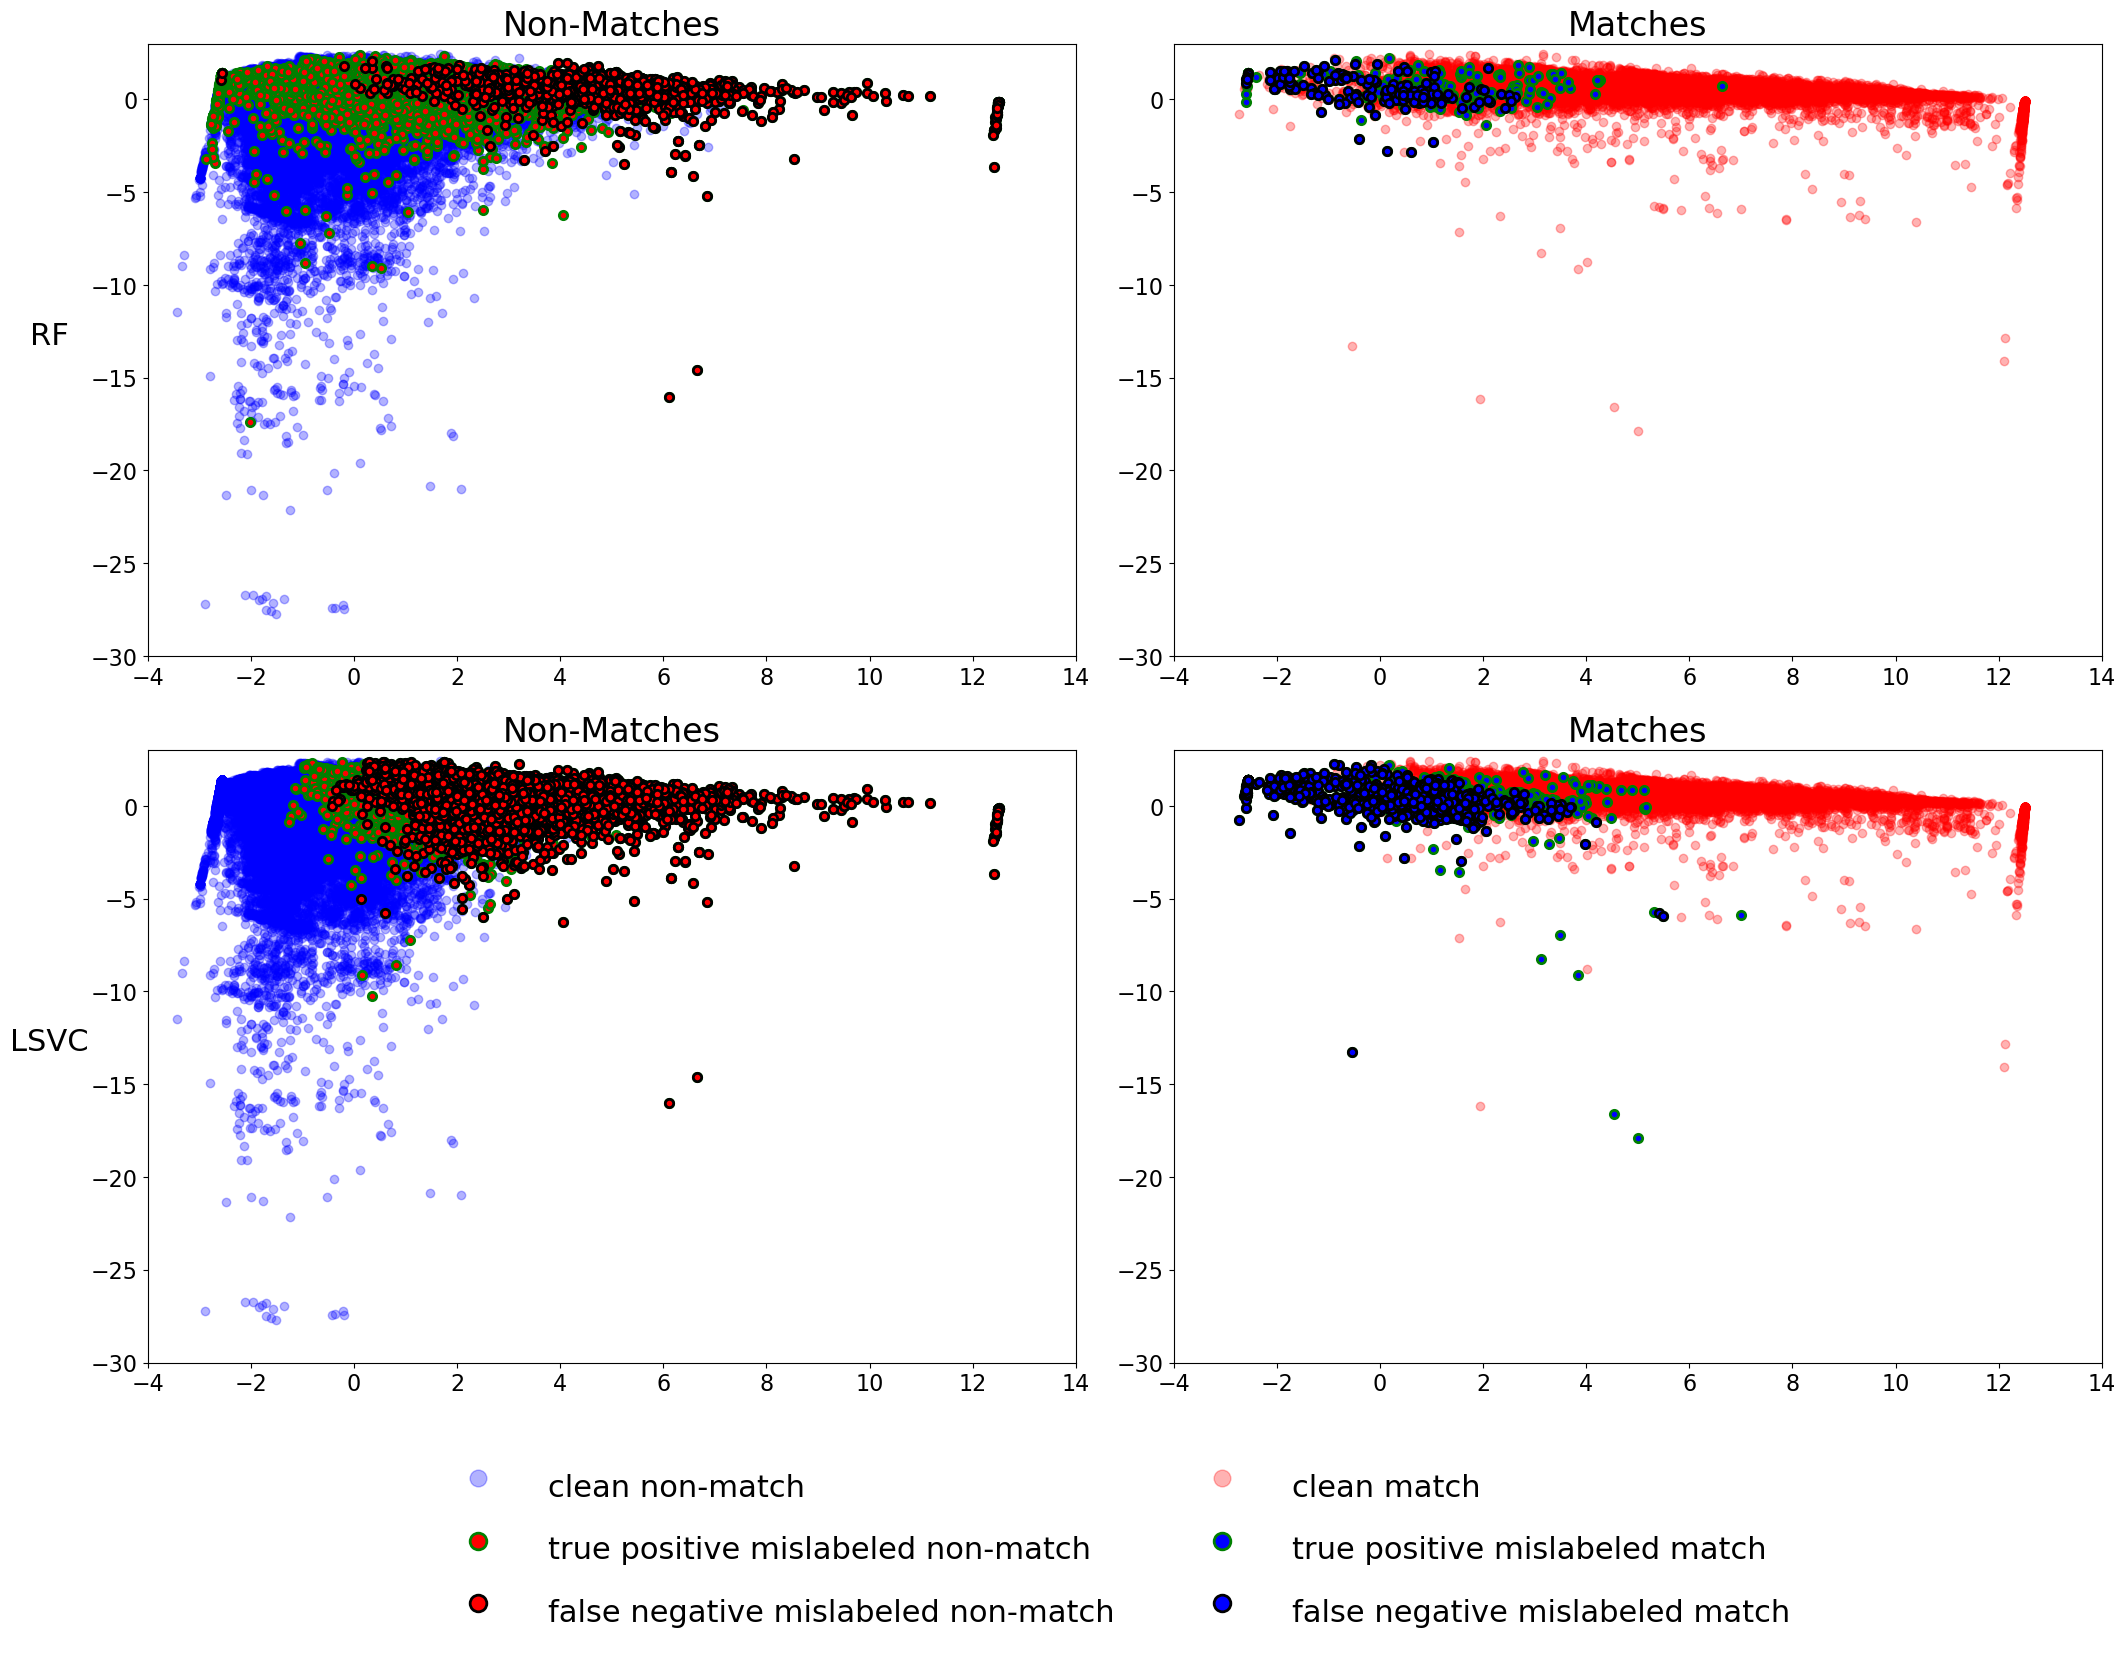

In [20]:
def get_reduced_data(data):
    X = data.drop(["label", "noisy_label", "is_in_fn"], axis=1)
    y = data["label"]

    match_indices = data[data["label"] == 1].index
    non_match_indices = data[data["label"] == 0].index

    mislabeled_indices = data[data["label"] != data["noisy_label"]].index
    mislabeled_match_indices = data[(data["label"] == 1) & (data["noisy_label"] == 0)].index
    mislabeled_non_match_indices = data[(data["label"] == 0) & (data["noisy_label"] == 1)].index

    fns = data[data["is_in_fn"]]
    mislabeled_match_fns_indices = fns[fns["label"] == 1].index
    mislabeled_non_match_fns_indices = fns[fns["label"] == 0].index

    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(X)

    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(scaled_data)

    mislabeled_pca = X_pca[mislabeled_indices]
    match_pca = X_pca[match_indices]
    non_match_pca = X_pca[non_match_indices]
    mislabeled_match_pca = X_pca[mislabeled_match_indices]
    mislabeled_non_match_pca = X_pca[mislabeled_non_match_indices]

    mislabeled_match_in_fn = X_pca[mislabeled_match_fns_indices]
    mislabeled_non_match_in_fn = X_pca[mislabeled_non_match_fns_indices]

    colors = data.iloc[mislabeled_indices].apply(lambda row: 'blue' if row["noisy_label"] == 0 else 'red', axis=1)

    return X_pca, y, non_match_pca, mislabeled_non_match_pca, match_pca, mislabeled_match_pca, mislabeled_pca, mislabeled_match_in_fn, mislabeled_non_match_in_fn, colors


fig, axs = plt.subplots(2, 2, figsize=figsize)

files = [
 ("../../datasets/music/music_most_values_rf_corrupted.csv"),
 ("../../datasets/music/music_most_values_svm_corrupted.csv")
]

results = []

for row_index, file in enumerate(files):

    corrupted_data = pd.read_csv(file)
    corrupted_feature_data = corrupted_data.drop(["label", "noisy_label"], axis=1)

    detector_instance = FKDN_Detector()
    issue_indices = detector_instance.detect(corrupted_feature_data, corrupted_data["noisy_label"].to_numpy())

    y_pred = [1 if i in issue_indices else 0 for i in np.arange(0, len(corrupted_data), 1)]
    y_true = corrupted_data.apply(lambda row: 0 if row["label"] == row["noisy_label"] else 1, axis=1).to_numpy()

    fn_indices = [index for index, value in enumerate(y_pred) if value == 0 and y_true[index] == 1]

    corrupted_data["is_in_fn"] = False
    corrupted_data.loc[fn_indices, "is_in_fn"] = True

    fns = corrupted_data.iloc[fn_indices]

    X_pca, y, non_match_pca, mislabeled_non_match_pca, match_pca, mislabeled_match_pca, mislabeled_pca, mislabeled_match_in_fn, mislabeled_non_match_in_fn, colors = get_reduced_data(corrupted_data)

    results.append(get_reduced_data(corrupted_data))

    axs[row_index][0].set_title('Non-Matches')
    axs[row_index][0].scatter(non_match_pca[:, 0], non_match_pca[:, 1],  color='blue', alpha=0.3, label='clean non-match')
    axs[row_index][0].scatter(mislabeled_non_match_pca[:, 0], mislabeled_non_match_pca[:, 1],  color='red', alpha=1, edgecolors='green', linewidths=2, label='true positive mislabeled non-match')
    axs[row_index][0].scatter(mislabeled_non_match_in_fn[:, 0], mislabeled_non_match_in_fn[:, 1],  color='red', alpha=1, edgecolors='black', linewidths=2, label='false negative mislabeled non-match')
    axs[row_index][0].set_xlim(-4, 14)
    axs[row_index][0].set_ylim(-30, 3)

    axs[row_index][1].set_title('Matches')
    axs[row_index][1].scatter(match_pca[:, 0], match_pca[:, 1],  color='red', alpha=0.3, label='clean match')
    axs[row_index][1].scatter(mislabeled_match_pca[:, 0], mislabeled_match_pca[:, 1],  color='blue', alpha=1, edgecolors='green', linewidths=2, label='true positive mislabeled match')
    axs[row_index][1].scatter(mislabeled_match_in_fn[:, 0], mislabeled_match_in_fn[:, 1],  color='blue', alpha=1, edgecolors='black', linewidths=2, label='false negative mislabeled match')
    axs[row_index][1].set_xlim(-4, 14)
    axs[row_index][1].set_ylim(-30, 3)

    print(file)
    print(f'number matches in fn = {len(mislabeled_match_in_fn)} | number non-matches in fn = {len(mislabeled_non_match_in_fn)}')

row_titles = ['RF', 'LSVC']
for i, title in enumerate(row_titles):
    axs[i, 0].set_ylabel(title, labelpad=30, rotation=0, loc='center')

handles = []
all_labels = []

axs = axs.flatten()

for i, ax in enumerate(axs):

    h, l = ax.get_legend_handles_labels()
    handles.extend(h)
    all_labels.extend(l)
    if i == 1:
        break

fig.legend(handles, all_labels, loc='lower center',
           bbox_to_anchor=(0.52, -0.1),
           ncol=2, frameon=False, markerscale=2, 
           handlelength=3,
           handleheight=2)

plt.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])
plt.show()

# Recall in the light of imbalance

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [16]:
from constants.visualization_defaults import FIG_SIZE, FONT_SIZE_PARAMS

plt.rcParams.update(FONT_SIZE_PARAMS) 

In [17]:

preprocessed_music = pd.read_csv('../../datasets/music/preprocessed_music_most_values.csv')

print(f'Imbalance: {(len(preprocessed_music[preprocessed_music["label"] == 0]) / len(preprocessed_music)):.2f} non matches | {(len(preprocessed_music[preprocessed_music["label"] == 1]) / len(preprocessed_music)):.2f} matches')

Imbalance: 0.96 non matches | 0.04 matches


In [18]:
music_rf = pd.read_csv('../../datasets/music/music_most_values_rf_corrupted.csv')
number_mislabeled = len(music_rf[music_rf["label"] != music_rf["noisy_label"]])

print(f'mislabeled non matches out of all mislabeled: {(len(music_rf[(music_rf["label"] == 0) & (music_rf["noisy_label"] == 1)]) / number_mislabeled):.2f}')
print(f'mislabeled matches out of all mislabeled: {(len(music_rf[(music_rf["label"] == 1) & (music_rf["noisy_label"] == 0)]) / number_mislabeled):.2f}')

print(f'in total {(len(music_rf[(music_rf["label"] == 0) & (music_rf["noisy_label"] == 1)]))} non matches out of {number_mislabeled} mislabeled')
print(f'in total {(len(music_rf[(music_rf["label"] == 1) & (music_rf["noisy_label"] == 0)]))} matches out of {number_mislabeled} mislabeled')


mislabeled non matches out of all mislabeled: 0.95
mislabeled matches out of all mislabeled: 0.05
in total 5744 non matches out of 6046 mislabeled
in total 302 matches out of 6046 mislabeled


In [19]:
music_svm = pd.read_csv('../../datasets/music/music_most_values_svm_corrupted.csv')
number_mislabeled = len(music_svm[music_svm["label"] != music_svm["noisy_label"]])

print(f'mislabeled non matches out of all mislabeled: {(len(music_svm[(music_svm["label"] == 0) & (music_svm["noisy_label"] == 1)]) / number_mislabeled):.2f}')
print(f'mislabeled matches out of all mislabeled: {(len(music_svm[(music_svm["label"] == 1) & (music_svm["noisy_label"] == 0)]) / number_mislabeled):.2f}')

print(f'in total {(len(music_svm[(music_svm["label"] == 0) & (music_svm["noisy_label"] == 1)]))} non matches out of {number_mislabeled} mislabeled')
print(f'in total {(len(music_svm[(music_svm["label"] == 1) & (music_svm["noisy_label"] == 0)]))} matches out of {number_mislabeled} mislabeled')

mislabeled non matches out of all mislabeled: 0.92
mislabeled matches out of all mislabeled: 0.08
in total 14498 non matches out of 15675 mislabeled
in total 1177 matches out of 15675 mislabeled


In [20]:
def compute_recall(probability_identifying_match_TP, probability_identifying_non_match_TP, corrupted_data):
    tp_matches = round(len(corrupted_data[(corrupted_data["label"] == 1) & (corrupted_data["noisy_label"] == 0)]) * probability_identifying_match_TP)
    fn_matches = len(corrupted_data[(corrupted_data["label"] == 1) & (corrupted_data["noisy_label"] == 0)]) - tp_matches

    assert tp_matches + fn_matches == len(corrupted_data[(corrupted_data["label"] == 1) & (corrupted_data["noisy_label"] == 0)])

    tp_non_matches = round(len(corrupted_data[(corrupted_data["label"] == 0) & (corrupted_data["noisy_label"] == 1)]) * probability_identifying_non_match_TP)
    fn_non_matches = len(corrupted_data[(corrupted_data["label"] == 0) & (corrupted_data["noisy_label"] == 1)]) - tp_non_matches

    assert tp_non_matches + fn_non_matches == len(corrupted_data[(corrupted_data["label"] == 0) & (corrupted_data["noisy_label"] == 1)])

    tp = tp_matches + tp_non_matches
    fn = fn_matches + fn_non_matches

    recall = tp / (tp + fn)

    return recall

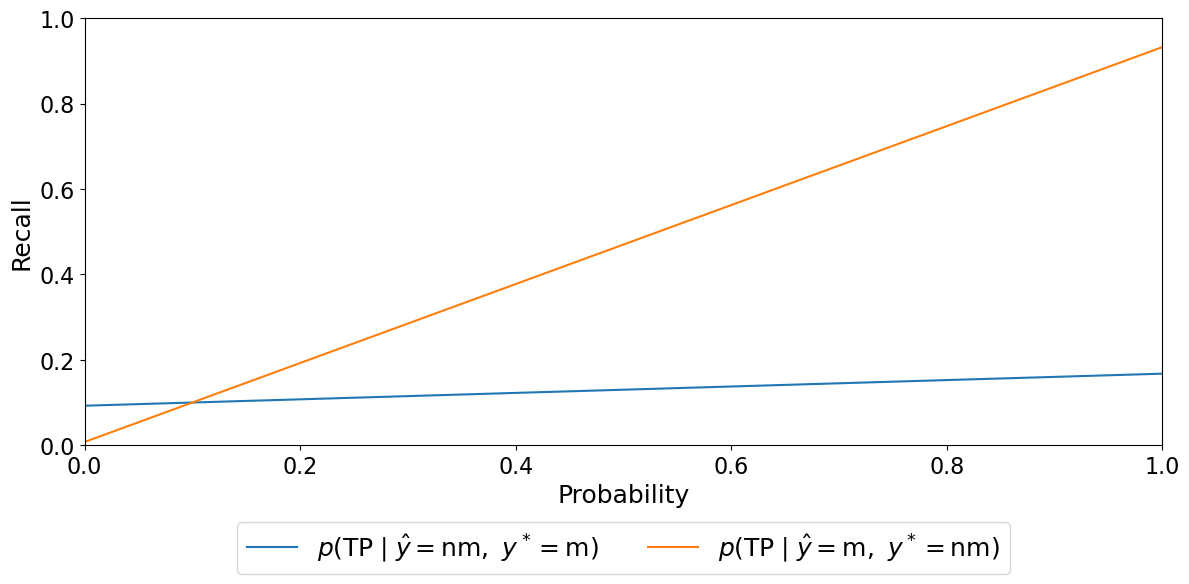

In [21]:
plt.figure(figsize=(12, 6))

x = np.arange(0, 1.1, 0.1)
y1 = [compute_recall(p_match, 0.1, music_svm) for p_match in x]
y2 = [compute_recall(0.1, p_non_match, music_svm) for p_non_match in x]

plt.plot(x, y1, label=r'$p(\mathrm{TP} \mid \hat{y} = \mathrm{nm},\ y^* = \mathrm{m})$')
plt.plot(x, y2, label=r'$p(\mathrm{TP} \mid \hat{y} = \mathrm{m},\ y^* = \mathrm{nm})$')

plt.xlabel("Probability")
plt.xlim(0, 1)

plt.ylabel("Recall")
plt.ylim(0, 1)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)
plt.tight_layout()
plt.show()



# Excerpt Mislabeled non-matches music

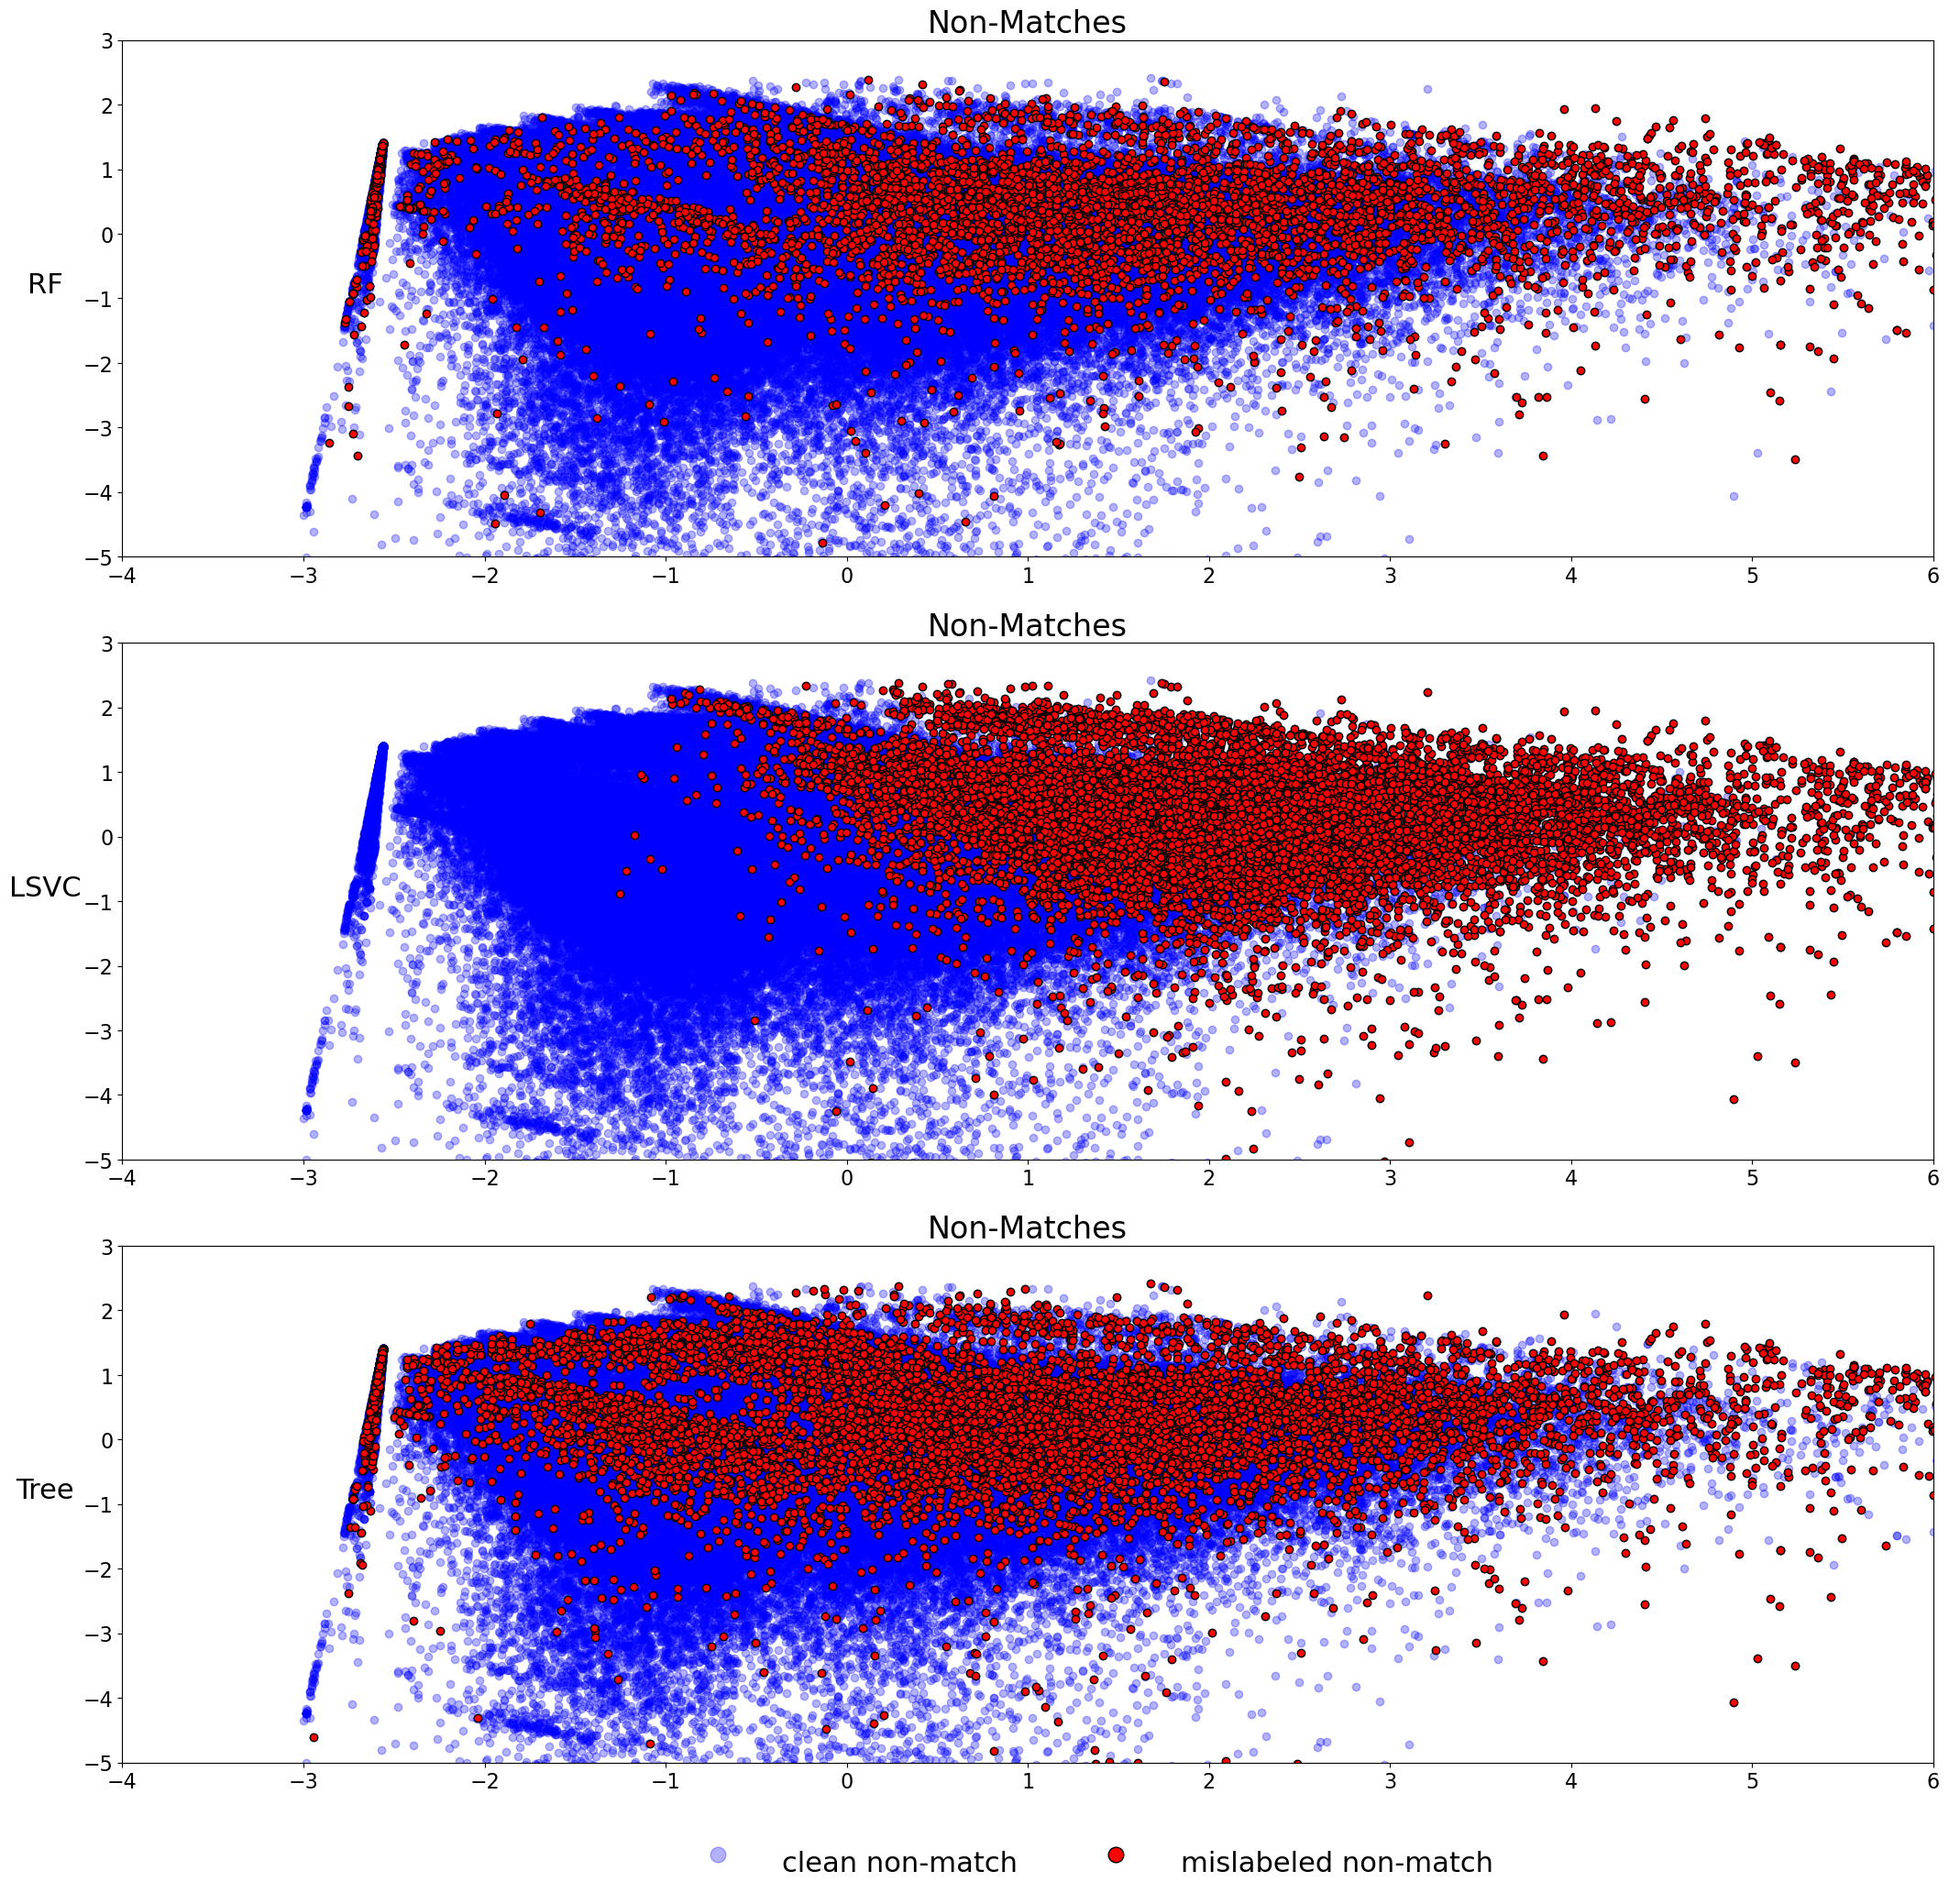

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

figsize = (24, 20) 
plt.rcParams.update(
 {
    'axes.titlesize': 24,   
    'axes.labelsize': 22,   
    'xtick.labelsize': 16,  
    'ytick.labelsize': 16,  
    'legend.fontsize': 22   
}) 

def get_reduced_data(file):
    data = pd.read_csv(file)

    X = data.drop(["label", "noisy_label"], axis=1)
    y = data["label"]

    match_indices = data[data["label"] == 1].index
    non_match_indices = data[data["label"] == 0].index

    mislabeled_indices = data[data["label"] != data["noisy_label"]].index
    mislabeled_match_indices = data[(data["label"] == 1) & (data["noisy_label"] == 0)].index
    mislabeled_non_match_indices = data[(data["label"] == 0) & (data["noisy_label"] == 1)].index

    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(X)

    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(scaled_data)

    mislabeled_pca = X_pca[mislabeled_indices]
    match_pca = X_pca[match_indices]
    non_match_pca = X_pca[non_match_indices]
    mislabeled_match_pca = X_pca[mislabeled_match_indices]
    mislabeled_non_match_pca = X_pca[mislabeled_non_match_indices]

    colors = data.iloc[mislabeled_indices].apply(lambda row: 'blue' if row["noisy_label"] == 0 else 'red', axis=1)

    return X_pca, y, non_match_pca, mislabeled_non_match_pca, match_pca, mislabeled_match_pca, mislabeled_pca, colors


fig, axs = plt.subplots(3, 1, figsize=figsize)

files = [
 ("../../datasets/music/music_most_values_rf_corrupted.csv"),
 ("../../datasets/music/music_most_values_svm_corrupted.csv"),
 ("../../datasets/music/music_most_values_tree_corrupted.csv"),
]


for row_index, file in enumerate(files):

    X_pca, y, non_match_pca, mislabeled_non_match_pca, match_pca, mislabeled_match_pca, mislabeled_pca, colors = get_reduced_data(file)

    axs[row_index].set_title('Non-Matches')
    axs[row_index].scatter(non_match_pca[:, 0], non_match_pca[:, 1],  color='blue', alpha=0.3, label="clean non-match")
    axs[row_index].scatter(mislabeled_non_match_pca[:, 0], mislabeled_non_match_pca[:, 1], color='red', edgecolors='black', alpha=1, label="mislabeled non-match")
    axs[row_index].set_xlim(-4, 6)
    axs[row_index].set_ylim(-5, 3)
    axs[row_index].set_xticks([-4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6])


row_titles = ['RF', 'LSVC', 'Tree']
for i, title in enumerate(row_titles):
    axs[i].set_ylabel(title, labelpad=30, rotation=0, loc='center')

axs = axs.flatten()

handles = []
all_labels = []

for i, ax in enumerate(axs):

    h, l = ax.get_legend_handles_labels()
    handles.extend(h)
    all_labels.extend(l)
    break

fig.legend(handles, all_labels, loc='lower center',
           bbox_to_anchor=(0.6, -0.05),  
           ncol=2, frameon=False, markerscale=2,   
           handlelength=3, 
           handleheight=2)


plt.tight_layout(rect=[0.1, 0, 1, 1])
plt.show()


# false positives clean matches

../../datasets/music/music_most_values_rf_corrupted.csv
number matches in fp = 821 | number non matches in fp = 1430
number clean matches = 13160 | number clean non matches = 286159
../../datasets/music/music_most_values_svm_corrupted.csv
number matches in fp = 379 | number non matches in fp = 3004
number clean matches = 12300 | number clean non matches = 286159


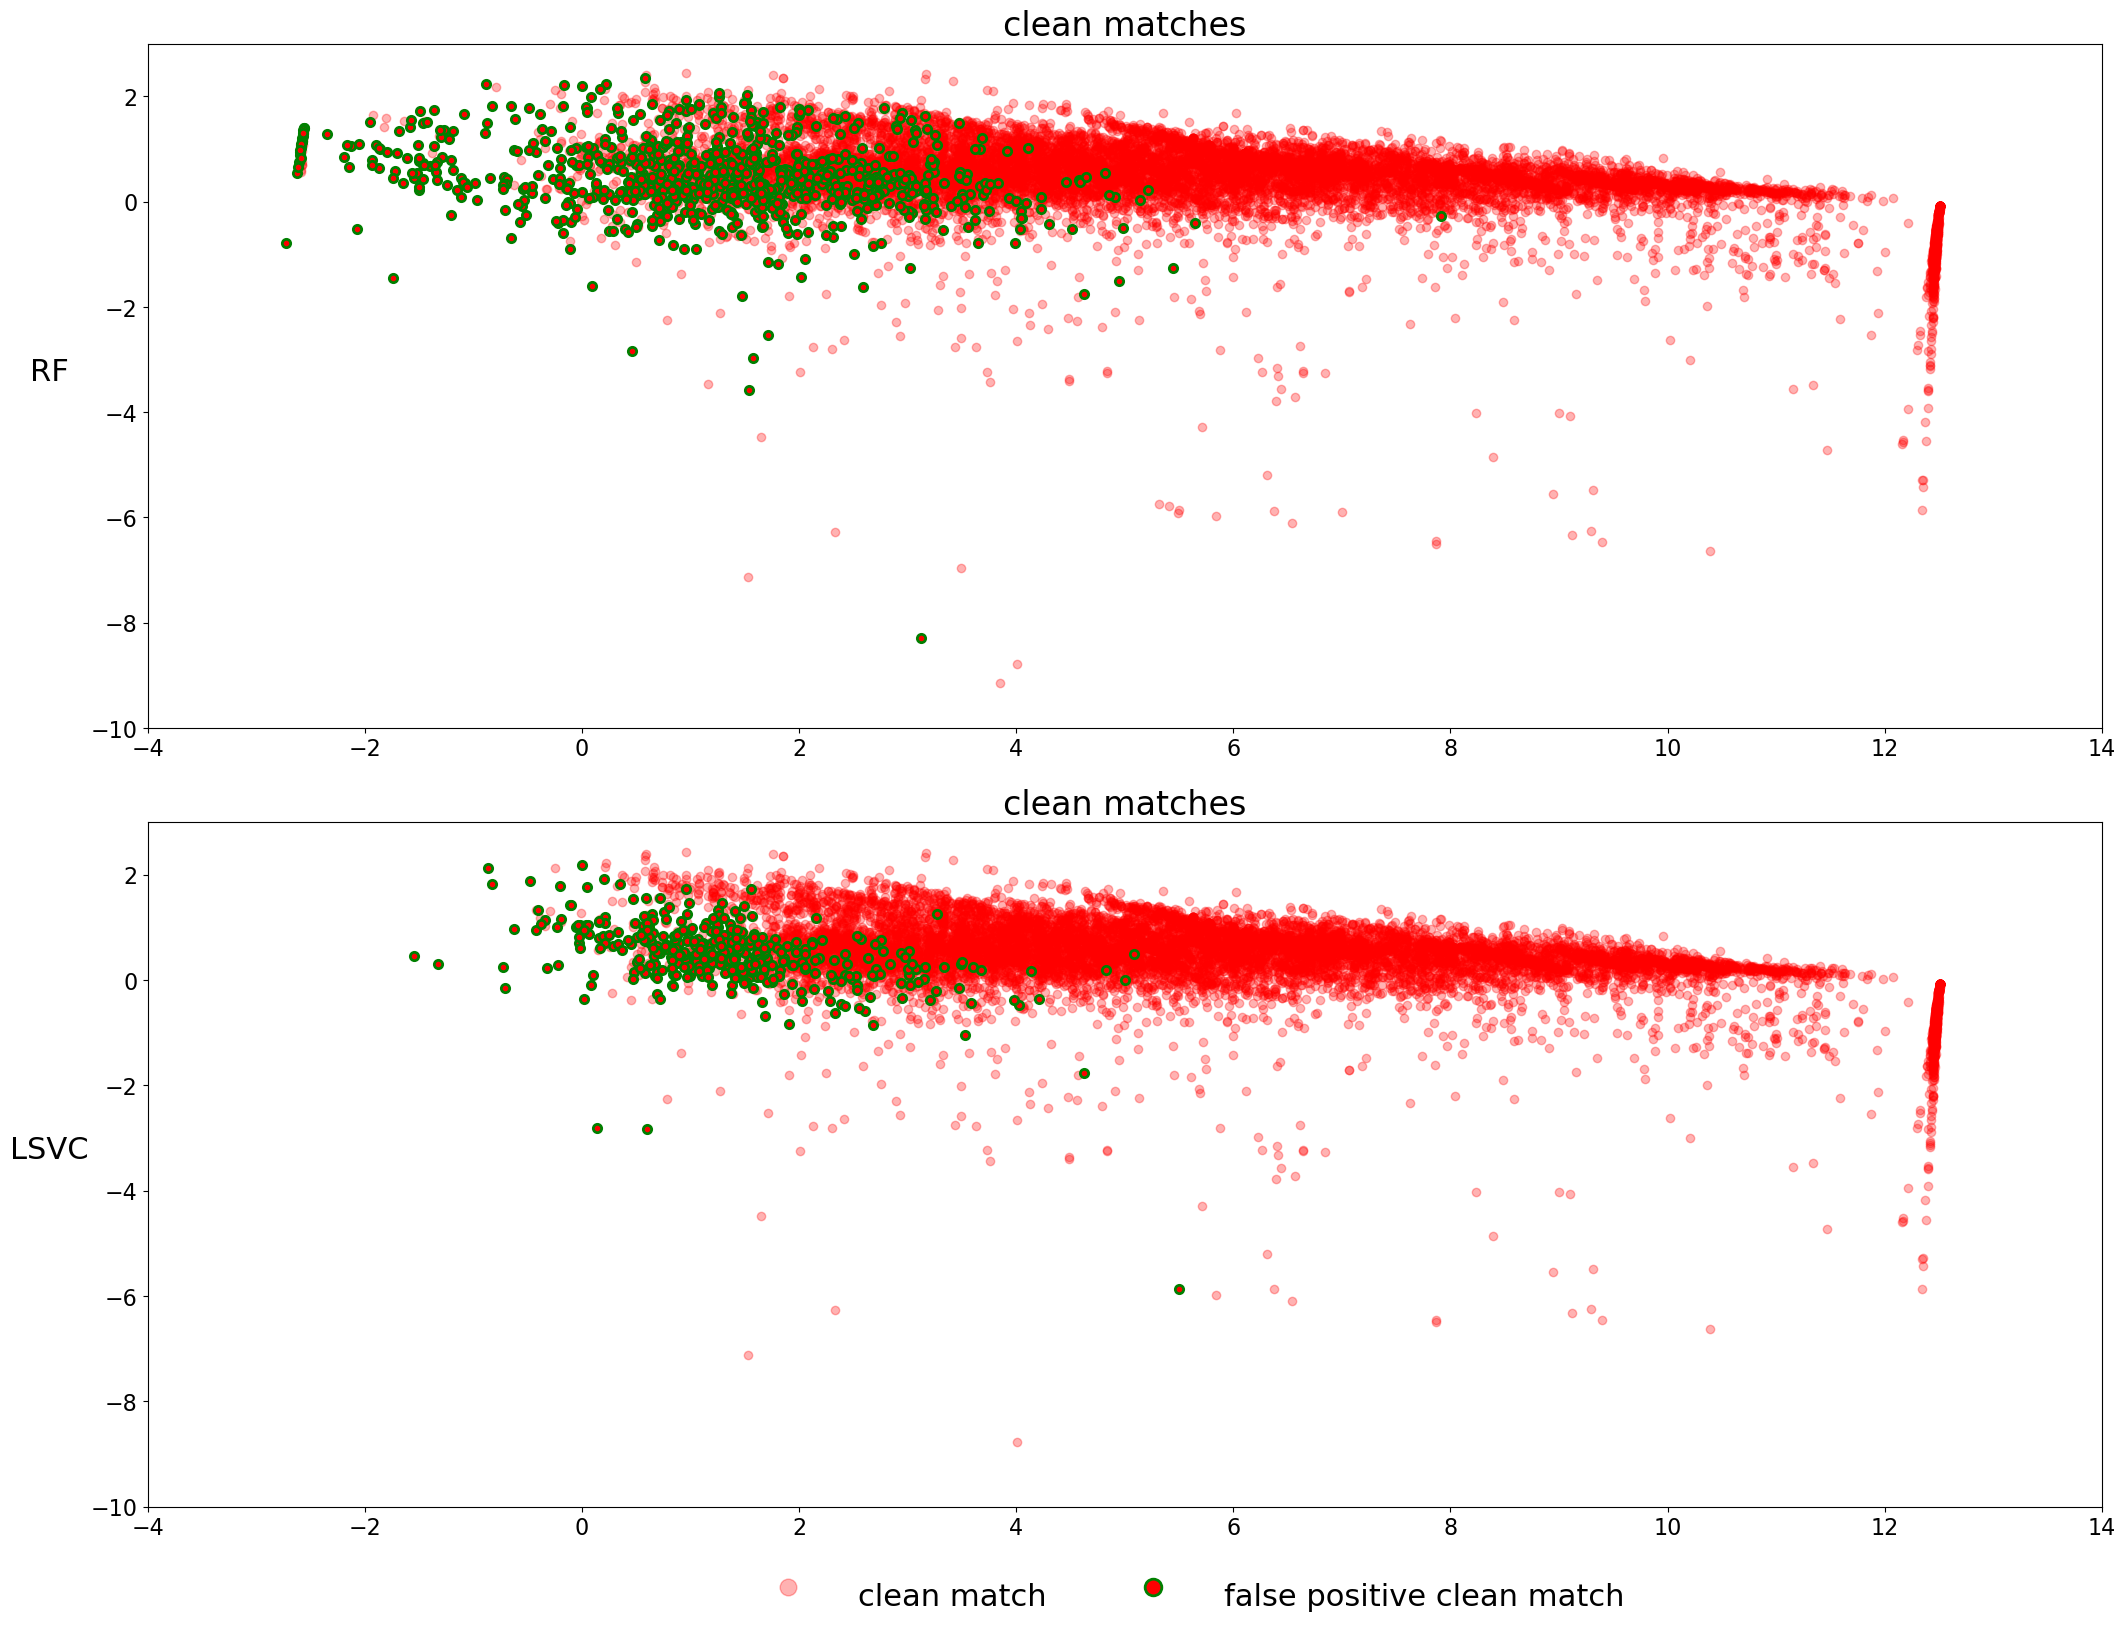

In [29]:
def get_reduced_data(data):
    X = data.drop(["label", "noisy_label", "is_in_fp"], axis=1)
    y = data["label"]

    clean_match_indices = data[(data["label"] == 1) & (data["noisy_label"] == 1)].index
    clean_non_match_indices = data[(data["label"] == 0) & (data["label"] == 0)].index

    mislabeled_indices = data[data["label"] != data["noisy_label"]].index

    fps = data[data["is_in_fp"]]
    match_fps_indices = fps[fps["label"] == 1].index
    non_match_fps_indices = fps[fps["label"] == 0].index

    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(X)

    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(scaled_data)

    mislabeled_pca = X_pca[mislabeled_indices]
    clean_match_pca = X_pca[clean_match_indices]
    clean_non_match_pca = X_pca[clean_non_match_indices]

    matches_in_fp = X_pca[match_fps_indices]
    non_matches_in_fp = X_pca[non_match_fps_indices]

    colors = data.iloc[mislabeled_indices].apply(lambda row: 'blue' if row["noisy_label"] == 0 else 'red', axis=1)

    return X_pca, y, clean_non_match_pca, clean_match_pca, mislabeled_pca, colors, matches_in_fp, non_matches_in_fp

figsize = (24, 16) 
plt.rcParams.update(
 {
    'axes.titlesize': 24,   
    'axes.labelsize': 22,   
    'xtick.labelsize': 16,  
    'ytick.labelsize': 16,  
    'legend.fontsize': 22   
}) 

fig, axs = plt.subplots(2, 1,figsize=figsize)

files = [
 ("../../datasets/music/music_most_values_rf_corrupted.csv"),
 ("../../datasets/music/music_most_values_svm_corrupted.csv")
]


for row_index, file in enumerate(files):

    corrupted_data = pd.read_csv(file)
    corrupted_feature_data = corrupted_data.drop(["label", "noisy_label"], axis=1)

    detector_instance = FKDN_Detector()
    issue_indices = detector_instance.detect(corrupted_feature_data, corrupted_data["noisy_label"].to_numpy())

    y_pred = [1 if i in issue_indices else 0 for i in np.arange(0, len(corrupted_data), 1)]
    y_true = corrupted_data.apply(lambda row: 0 if row["label"] == row["noisy_label"] else 1, axis=1).to_numpy()

    fp_indices = [index for index, value in enumerate(y_pred) if value == 1 and y_true[index] == 0]

    corrupted_data["is_in_fp"] = False
    corrupted_data.loc[fp_indices, "is_in_fp"] = True

    fps = corrupted_data.iloc[fp_indices]

    X_pca, y, clean_non_match_pca, clean_match_pca, mislabeled_pca, colors, matches_in_fp, non_matches_in_fp = get_reduced_data(corrupted_data)

    axs[row_index].set_title('clean matches')
    axs[row_index].scatter(clean_match_pca[:, 0], clean_match_pca[:, 1],  color='red', alpha=0.3, label='clean match')
    axs[row_index].scatter(matches_in_fp[:, 0], matches_in_fp[:, 1],  color='red', alpha=1, edgecolors='green', linewidths=2, label='false positive clean match')
    axs[row_index].set_xlim(-4, 14)
    axs[row_index].set_ylim(-10, 3)

    print(file)
    print(f'number matches in fp = {len(matches_in_fp)} | number non matches in fp = {len(non_matches_in_fp)}')
    print(f'number clean matches = {len(clean_match_pca)} | number clean non matches = {len(clean_non_match_pca)}')


row_titles = ['RF', 'LSVC']
for i, title in enumerate(row_titles):
    axs[i].set_ylabel(title, labelpad=30, rotation=0, loc='center')


axs = axs.flatten()

handles = []
all_labels = []

for i, ax in enumerate(axs):
    h, l = ax.get_legend_handles_labels()
    handles.extend(h)
    all_labels.extend(l)
    break


fig.legend(handles, all_labels, loc='lower center',
           bbox_to_anchor=(0.6, -0.05),
           ncol=2, frameon=False, markerscale=2,   
           handlelength=3, 
           handleheight=2)


plt.tight_layout(rect=[0.1, 0, 1, 0.99])
plt.show()

# Precision varying false positive identifications

In [30]:
from constants.visualization_defaults import FIG_SIZE, FONT_SIZE_PARAMS

plt.rcParams.update(FONT_SIZE_PARAMS) 

In [31]:
import pandas as pd

preprocessed_music = pd.read_csv('../../datasets/music/preprocessed_music_most_values.csv')

print(f'Imbalance: {(len(preprocessed_music[preprocessed_music["label"] == 0]) / len(preprocessed_music)):.2f} non matches | {(len(preprocessed_music[preprocessed_music["label"] == 1]) / len(preprocessed_music)):.2f} matches')

Imbalance: 0.96 non matches | 0.04 matches


In [32]:
music_rf = pd.read_csv('../../datasets/music/music_most_values_rf_corrupted.csv')
number_mislabeled = len(music_rf[music_rf["label"] != music_rf["noisy_label"]])

print(f'mislabeled non matches out of all mislabeled: {(len(music_rf[(music_rf["label"] == 0) & (music_rf["noisy_label"] == 1)]) / number_mislabeled):.2f}')
print(f'mislabeled matches out of all mislabeled: {(len(music_rf[(music_rf["label"] == 1) & (music_rf["noisy_label"] == 0)]) / number_mislabeled):.2f}')

print(f'in total {(len(music_rf[(music_rf["label"] == 0) & (music_rf["noisy_label"] == 1)]))} non matches out of {number_mislabeled} mislabeled')
print(f'in total {(len(music_rf[(music_rf["label"] == 1) & (music_rf["noisy_label"] == 0)]))} matches out of {number_mislabeled} mislabeled')


mislabeled non matches out of all mislabeled: 0.95
mislabeled matches out of all mislabeled: 0.05
in total 5783 non matches out of 6093 mislabeled
in total 310 matches out of 6093 mislabeled


In [33]:
def compute_precision(probability_identifying_match_FP, probability_identifying_non_match_FP, corrupted_data):
    tp = 4000

    match_fp = round(len(corrupted_data[(corrupted_data["noisy_label"] == corrupted_data["label"]) & corrupted_data["label"] == 1]) * probability_identifying_match_FP)
    non_match_fp = round(len(corrupted_data[(corrupted_data["noisy_label"] == corrupted_data["label"]) & corrupted_data["label"] == 0]) * probability_identifying_non_match_FP)

    fp = match_fp + non_match_fp

    return tp / (tp + fp)



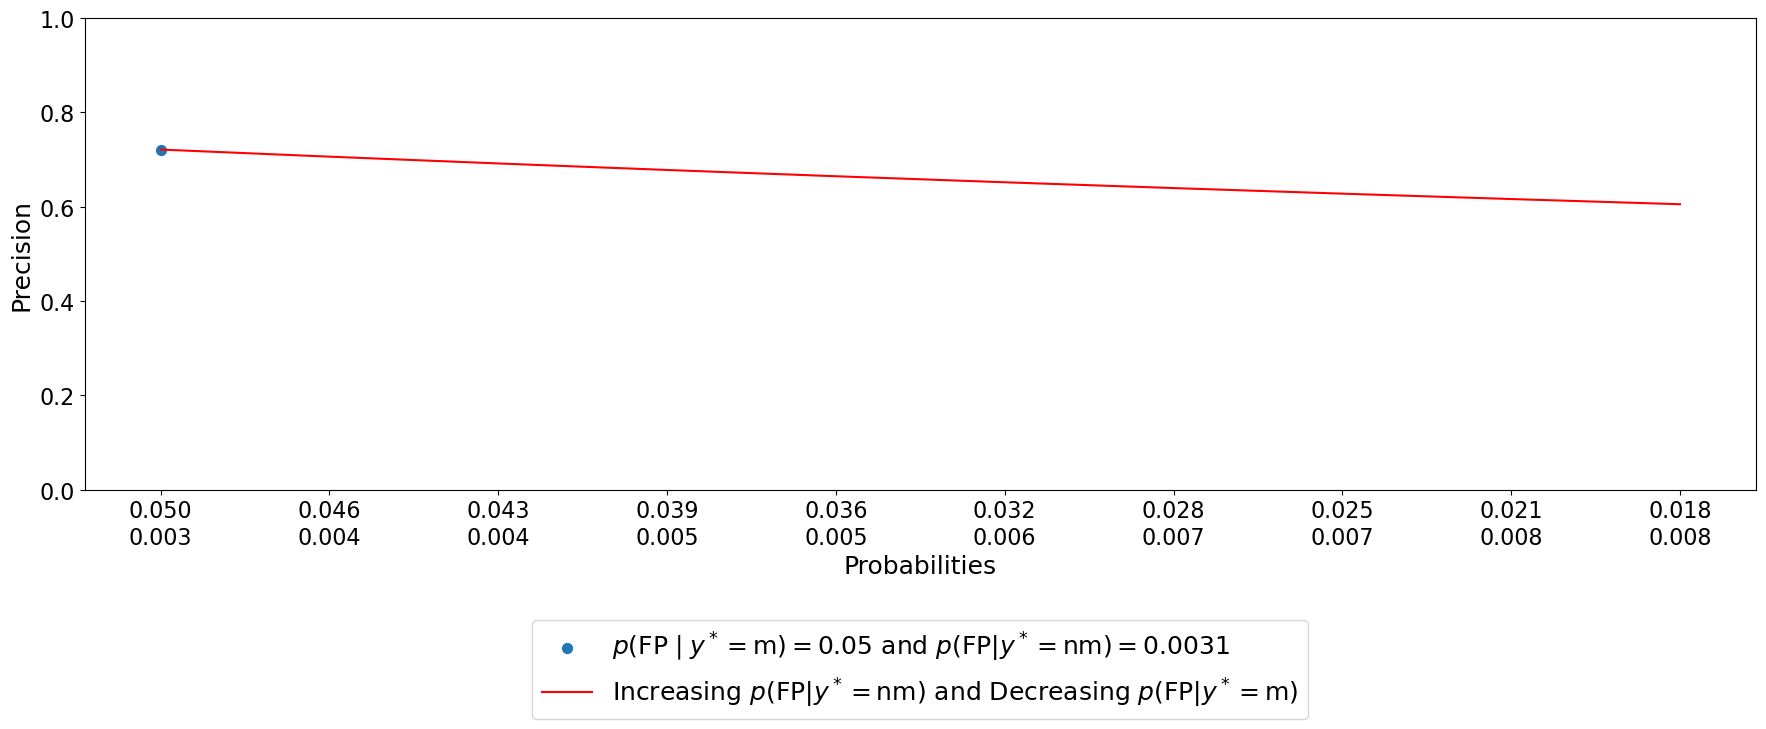

In [34]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(0, 1.1, 0.1)

x1 = np.linspace(0.05, 0.0175, 10)
x2 = np.linspace(0.0031, 0.0083, 10)

d2 = compute_precision(0.05, 0.0031, music_rf)
y3 = [compute_precision(p_match, p_non_match, music_rf) for p_match, p_non_match in zip(x1, x2)]

plt.figure(figsize=FIG_SIZE)

plt.scatter(0, d2, s=50, label=r"$p(\mathrm{FP} \mid y^*=\mathrm{m}) = 0.05$ and $p(\mathrm{FP}|y^*=\mathrm{nm}) = 0.0031$")
plt.plot(range(10), y3, label=r'Increasing $p(\mathrm{FP}|y^*=\mathrm{nm})$ and Decreasing $p(\mathrm{FP}|y^*=\mathrm{m})$', color="red")

x_ticks = [f'{val1:.3f}\n{val2:.3f}' for val1, val2 in zip(x1, x2)]

plt.ylabel("Precision")
plt.xlabel("Probabilities")
plt.ylim(0, 1)

plt.xticks(ticks=range(len(y3)), labels=x_ticks)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=1)
plt.tight_layout() 
plt.show()


# Overcleansing comparison SLN, CCN, RLN

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from util.corrupt_data import corrupt_data
from util.get_out_of_sample_predicted_probabilities_from_teacher_model import get_out_of_sample_predicted_probabilities_from_teacher_model
from util.create_bins import create_bins
from util.compute_mislabeling_probabilities import compute_mislabeling_probabilities
from sklearn.ensemble import RandomForestClassifier

from constants.visualization_defaults import FIG_SIZE, FONT_SIZE_PARAMS

plt.rcParams.update(FONT_SIZE_PARAMS) 

In [49]:
import pandas as pd
from util.create_artificial_dataset import corrupt_ccn, corrupt_sln

music = pd.read_csv("../../datasets/music/preprocessed_music_most_values.csv")

ccn_corrupted = corrupt_ccn(music, 0.018, 0.08)
sln_corrupted = corrupt_sln(music, 0.02)

In [50]:
data = music

input_data = data.copy()
binning_method = 'clustering_efficient'
feature_data = input_data.drop(['label'], axis=1)
bins = create_bins(feature_data, binning_method, 'music_most_values')

data = get_out_of_sample_predicted_probabilities_from_teacher_model(data, clf=RandomForestClassifier(), stratified_training=True, scale_feature_data=False)
data["bin"] = bins

data = compute_mislabeling_probabilities(data)

data = data.drop(["predicted_label", "bin"], axis=1)

corrupted_data = corrupt_data(data)
iln_corrupted = corrupted_data.drop("mislabeling_probability", axis=1)

In [51]:
print(f'ILN noise rate {((len(iln_corrupted[iln_corrupted["label"] != iln_corrupted["noisy_label"]]) / len(iln_corrupted)) * 100):.3f} %')
print(f'ccn noise rate {((len(ccn_corrupted[ccn_corrupted["label"] != ccn_corrupted["noisy_label"]]) / len(ccn_corrupted)) * 100):.3f} %')
print(f'sln noise rate {((len(sln_corrupted[sln_corrupted["label"] != sln_corrupted["noisy_label"]]) / len(sln_corrupted)) * 100):.3f} %')

ILN noise rate 2.047 %
ccn noise rate 2.042 %
sln noise rate 1.990 %


In [52]:
def get_tp_fn_fp(corrupted_data):
    correctly_labeled = corrupted_data[corrupted_data["label"] == corrupted_data["noisy_label"]]
    mislabeled = corrupted_data[corrupted_data["label"] != corrupted_data["noisy_label"]]

    tp = mislabeled[:3688]
    fn = mislabeled[3689:]

    fp_no_overcleansing = correctly_labeled.sample(n=2459)

    correctly_labeled_matches = correctly_labeled[correctly_labeled["label"] == 1]
    correctly_labeled_non_matches = correctly_labeled[correctly_labeled["label"] == 0]

    fp_overcleansing = pd.concat([correctly_labeled_matches[:1250], correctly_labeled_non_matches[:1209]], axis=0)

    return tp, fn, fp_no_overcleansing, fp_overcleansing

In [53]:
iln_tp, iln_fn, iln_fp_no_overcleansing, iln_fp_overcleansing = get_tp_fn_fp(iln_corrupted)
ccn_tp, ccn_fn, ccn_fp_no_overcleansing, ccn_fp_overcleansing = get_tp_fn_fp(ccn_corrupted)
sln_tp, sln_fn, sln_fp_no_overcleansing, sln_fp_overcleansing = get_tp_fn_fp(sln_corrupted)

In [54]:
def train_evaluate_classifier(x_train, y_train, x_test, y_test, clf):

    assert 'label' not in x_train.columns 
    assert 'noisy_label' not in x_train.columns 

    assert 'label' not in x_test.columns 
    assert 'noisy_label' not in x_test.columns 

    clf.fit(x_train, y_train)

    y_true = y_test
    y_pred = clf.predict(x_test)

    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)

    return precision, recall, f1, acc

In [55]:
base_estimator = DecisionTreeClassifier(max_depth=1)

adaboost_clf = AdaBoostClassifier(estimator=base_estimator)

In [56]:
iln_cleaned_no_overcleansing = iln_corrupted.drop(list(iln_tp.index) + list(iln_fp_no_overcleansing.index))
iln_cleaned_overcleansing = iln_corrupted.drop(list(iln_tp.index) + list(iln_fp_overcleansing.index))

ccn_cleaned_no_overcleansing = ccn_corrupted.drop(list(ccn_tp.index) + list(ccn_fp_no_overcleansing.index))
ccn_cleaned_overcleansing = ccn_corrupted.drop(list(ccn_tp.index) + list(ccn_fp_overcleansing.index))

sln_cleaned_no_overcleansing = sln_corrupted.drop(list(sln_tp.index) + list(sln_fp_no_overcleansing.index))
sln_cleaned_overcleansing = sln_corrupted.drop(list(sln_tp.index) + list(sln_fp_overcleansing.index))

In [57]:
iln_corrupted = iln_corrupted.drop("label", axis=1).rename(columns={'noisy_label': 'label'})
iln_cleaned_no_overcleansing = iln_cleaned_no_overcleansing.drop("label", axis=1).rename(columns={'noisy_label': 'label'})
iln_cleaned_overcleansing = iln_cleaned_overcleansing.drop("label", axis=1).rename(columns={'noisy_label': 'label'})

ccn_corrupted = ccn_corrupted.drop("label", axis=1).rename(columns={'noisy_label': 'label'})
ccn_cleaned_no_overcleansing = ccn_cleaned_no_overcleansing.drop("label", axis=1).rename(columns={'noisy_label': 'label'})
ccn_cleaned_overcleansing = ccn_cleaned_overcleansing.drop("label", axis=1).rename(columns={'noisy_label': 'label'})

sln_corrupted = sln_corrupted.drop("label", axis=1).rename(columns={'noisy_label': 'label'})
sln_cleaned_no_overcleansing = sln_cleaned_no_overcleansing.drop("label", axis=1).rename(columns={'noisy_label': 'label'})
sln_cleaned_overcleansing = sln_cleaned_overcleansing.drop("label", axis=1).rename(columns={'noisy_label': 'label'})

In [58]:
clean = music

clean_train, clean_test = train_test_split(clean, test_size=0.2, random_state=1)

clean_precision, clean_recall, clean_f1, clean_acc = train_evaluate_classifier(clean_train.drop("label", axis=1),
                                                                            clean_train["label"],
                                                                            clean_test.drop("label", axis=1),
                                                                            clean_test["label"],
                                                                            clf=adaboost_clf)

_, _, iln_corrupted_f1, _ = train_evaluate_classifier(iln_corrupted.drop("label", axis=1),
                                                                            iln_corrupted["label"],
                                                                            clean_test.drop("label", axis=1),
                                                                            clean_test["label"],
                                                                            clf=adaboost_clf)

_, _, ccn_corrupted_f1, _ = train_evaluate_classifier(ccn_corrupted.drop("label", axis=1),
                                                                            ccn_corrupted["label"],
                                                                            clean_test.drop("label", axis=1),
                                                                            clean_test["label"],
                                                                            clf=adaboost_clf)

_, _, sln_corrupted_f1, _ = train_evaluate_classifier(sln_corrupted.drop("label", axis=1),
                                                                            sln_corrupted["label"],
                                                                            clean_test.drop("label", axis=1),
                                                                            clean_test["label"],
                                                                            clf=adaboost_clf)

_, _, iln_cleaned_no_overcleansing_f1, _ = train_evaluate_classifier(iln_cleaned_no_overcleansing.drop("label", axis=1),
                                                                            iln_cleaned_no_overcleansing["label"],
                                                                            clean_test.drop("label", axis=1),
                                                                            clean_test["label"],
                                                                            clf=adaboost_clf)


_, _, iln_cleaned_overcleansing_f1, _ = train_evaluate_classifier(iln_cleaned_overcleansing.drop("label", axis=1),
                                                                            iln_cleaned_overcleansing["label"],
                                                                            clean_test.drop("label", axis=1),
                                                                            clean_test["label"],
                                                                            clf=adaboost_clf)

_, _, ccn_cleaned_no_overcleansing_f1, _ = train_evaluate_classifier(ccn_cleaned_no_overcleansing.drop("label", axis=1),
                                                                            ccn_cleaned_no_overcleansing["label"],
                                                                            clean_test.drop("label", axis=1),
                                                                            clean_test["label"],
                                                                            clf=adaboost_clf)

_, _, ccn_cleaned_overcleansing_f1, _ = train_evaluate_classifier(ccn_cleaned_overcleansing.drop("label", axis=1),
                                                                            ccn_cleaned_overcleansing["label"],
                                                                            clean_test.drop("label", axis=1),
                                                                            clean_test["label"],
                                                                            clf=adaboost_clf)

_, _, sln_cleaned_no_overcleansing_f1, _ = train_evaluate_classifier(sln_cleaned_no_overcleansing.drop("label", axis=1),
                                                                            sln_cleaned_no_overcleansing["label"],
                                                                            clean_test.drop("label", axis=1),
                                                                            clean_test["label"],
                                                                            clf=adaboost_clf)

_, _, sln_cleaned_overcleansing_f1, _ = train_evaluate_classifier(sln_cleaned_overcleansing.drop("label", axis=1),
                                                                            sln_cleaned_overcleansing["label"],
                                                                            clean_test.drop("label", axis=1),
                                                                            clean_test["label"],
                                                                            clf=adaboost_clf)




In [59]:
y_iln = [iln_corrupted_f1, iln_cleaned_no_overcleansing_f1, iln_cleaned_overcleansing_f1]
y_ccn = [ccn_corrupted_f1, ccn_cleaned_no_overcleansing_f1, ccn_cleaned_overcleansing_f1]
y_sln = [sln_corrupted_f1, sln_cleaned_no_overcleansing_f1, sln_cleaned_overcleansing_f1]

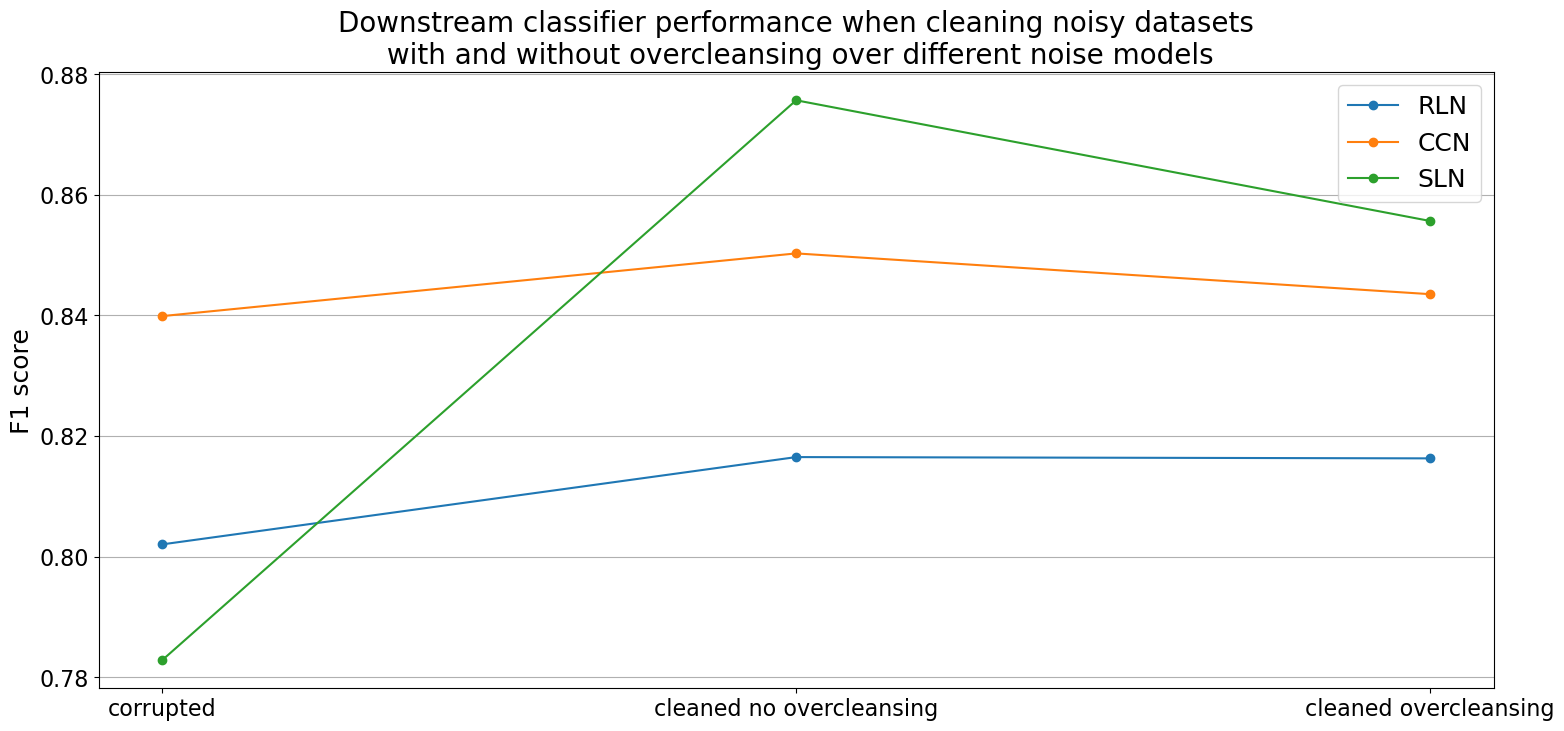

In [60]:
x = [0, 1, 2]

plt.figure(figsize=FIG_SIZE)

plt.plot(x, y_iln, label='RLN', marker='o')
plt.plot(x, y_ccn, label='CCN', marker='o')
plt.plot(x, y_sln, label='SLN', marker='o')

plt.xticks([0, 1, 2], labels=['corrupted', 'cleaned no overcleansing', 'cleaned overcleansing'])
plt.title("Downstream classifier performance when cleaning noisy datasets\n with and without overcleansing over different noise models")
plt.ylabel("F1 score")
plt.grid(axis='y')
plt.legend()
plt.show()